## SPOTIFY 100000 Playlists Data

In [0]:
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import json
import requests
import warnings

# Make the graphs a bit bigger
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
warnings.filterwarnings('ignore')



### Read the data from CSV files and perform data transformations

In [0]:
## A lot of data manipulation had to be done to get data into csv files. Please consult all the preprocessing steps in preprocessing notebook
tracks = pd.read_csv('https://www.dropbox.com/s/rmdjs9yns0vrwqz/tracks.csv?dl=1')
albums = pd.read_csv('https://www.dropbox.com/s/v1gn7u1gi7uw7mm/albums.csv?dl=1')
artists = pd.read_csv('https://www.dropbox.com/s/rdi2otrhen480ef/artists.csv?dl=1')
track_features = pd.read_csv('https://www.dropbox.com/s/o4kvdus9nu2zu05/track_features.csv?dl=1')
tracks_I_like = pd.read_csv('https://www.dropbox.com/s/o4kr73nhqvhja0m/tracks_i_like.csv?dl=1')

In [0]:
## Extract year from release_date column. This column is mixed with some date
## values and some year values. The below logic fixes that and creates a release_year column
year_albums = albums[albums['release_date'].str.isnumeric()]
year_albums['release_year'] = year_albums['release_date']
date_albums = albums[~albums['release_date'].str.isnumeric()]
date_albums['release_date'] = pd.to_datetime(date_albums['release_date'], errors='coerce')
date_albums['release_year'] = date_albums['release_date'].dt.year
albums = pd.concat([year_albums, date_albums])
albums = albums.drop('release_date', axis = 1)

In [0]:
### Remove all the songs that are in less than 5 playlists. As we are only looking for large trends, we can remove
### the smaller culprits and frees up our data for faster processing. Also getting track features from spotify API is
### computationally expensive and this helps us bypass that issue
pop_tracks = tracks[['pid','track_uri']].drop_duplicates()
ats = pd.DataFrame(pop_tracks['track_uri'].value_counts()).reset_index()
ats = ats.rename(columns = {'index':'track_uri','track_uri':'count'})
pop_tracks = ats[ats['count'] > 5]

tracks1 = pd.merge(tracks, pop_tracks[['track_uri']], on = ['track_uri'])

In [0]:
## Merge albums and artists and track_features with tracks table. This is the mother data frame on which we do all kinds of analysis
tracks2 = pd.merge(tracks1, albums, on=['album_uri'])
tracks2['release_year'] = pd.to_numeric(tracks2['release_year'])
tracks2['decade'] = (tracks2['release_year']//10) * 10
tracks2.decade = tracks2.decade.astype(int)
tracks2.release_year = tracks2.release_year.astype(int)
tracks2 = pd.merge(tracks2, artists, on=['artist_uri'], how = 'left')
tracks2 = pd.merge(tracks2, track_features, on=['track_uri'],how = 'left')

### Metrics

In [6]:
num_playlists = len(tracks2['pid'].drop_duplicates())
num_playlists

print("Original Data")
print("Number of Playlists: " + str(len(tracks['pid'].drop_duplicates())))
print("Number of Tracks: " + str(len(tracks['track_uri'].drop_duplicates())))
print("Number of Albums: " + str(len(tracks['album_uri'].drop_duplicates())))
print("Number of Artists: " + str(len(tracks['artist_uri'].drop_duplicates())))
print("-------")
print("Filtered Data")
print("Number of Playlists: " + str(len(tracks2['pid'].drop_duplicates())))
print("Number of Tracks: " + str(len(tracks2['track_uri'].drop_duplicates())))
print("Number of Albums: " + str(len(tracks2['album_uri'].drop_duplicates())))
print("Number of Artists: " + str(len(tracks2['artist_uri'].drop_duplicates())))

Original Data
Number of Playlists: 98000
Number of Tracks: 674702
Number of Albums: 269034
Number of Artists: 109116
-------
Filtered Data
Number of Playlists: 97539
Number of Tracks: 111469
Number of Albums: 50956
Number of Artists: 20089


### Most Popular artist

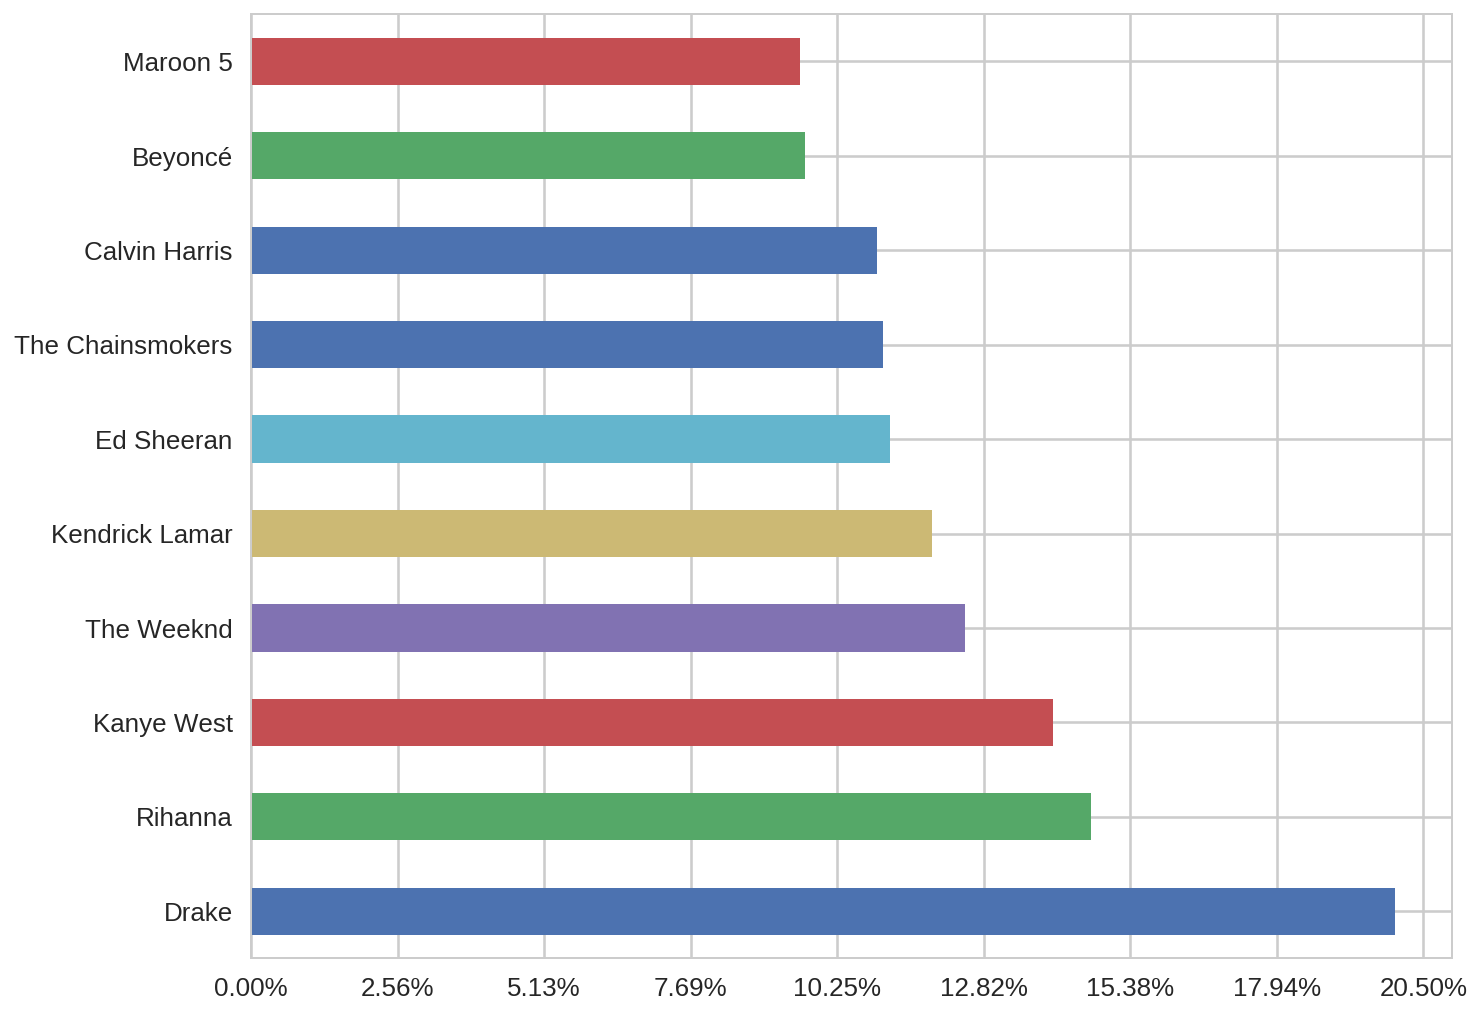

In [7]:
# So drake was the leading artist appearing in 18000 or 18% of playlists
pop_artists = tracks2[['pid','artist_name']].drop_duplicates()
ax = pop_artists['artist_name'].value_counts()[:10].plot(kind = 'barh')

vals = ax.get_xticks()
vals = vals/num_playlists
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.tight_layout()

### Most Popular Album

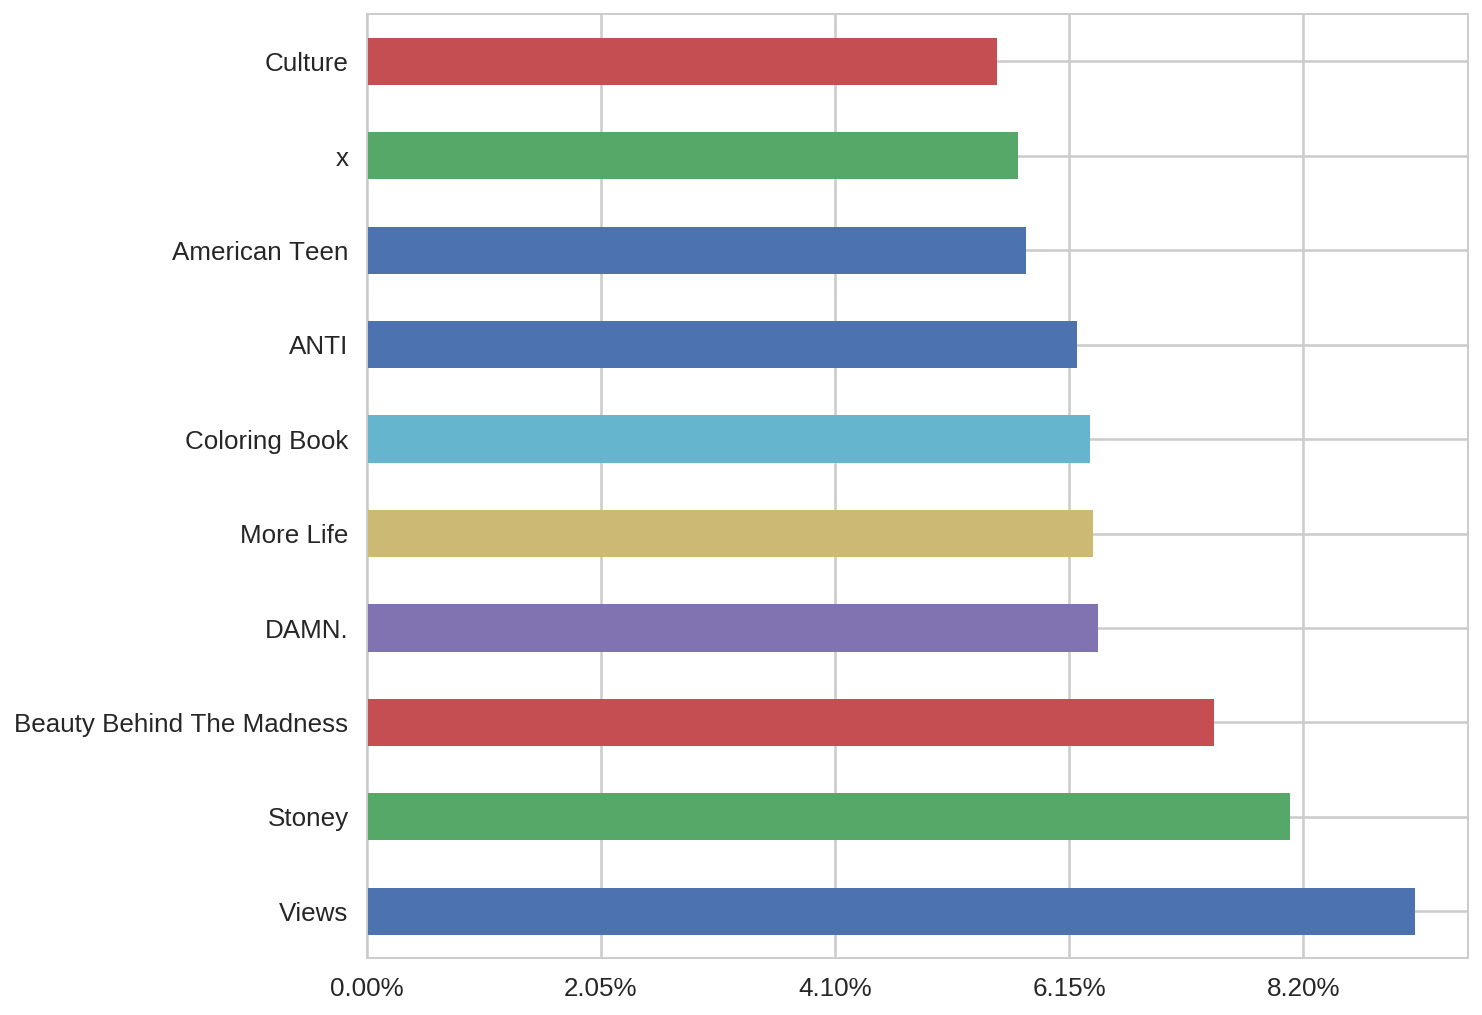

In [8]:
#Most popular albums in 10000 playlists
pop_albums = tracks2[tracks2['album_type'] == 'album'][['pid','album_name']].drop_duplicates()
ax = pop_albums['album_name'].value_counts()[:10].plot(kind = 'barh')

vals = ax.get_xticks()
vals = vals/num_playlists
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.tight_layout()

### Most popular Track

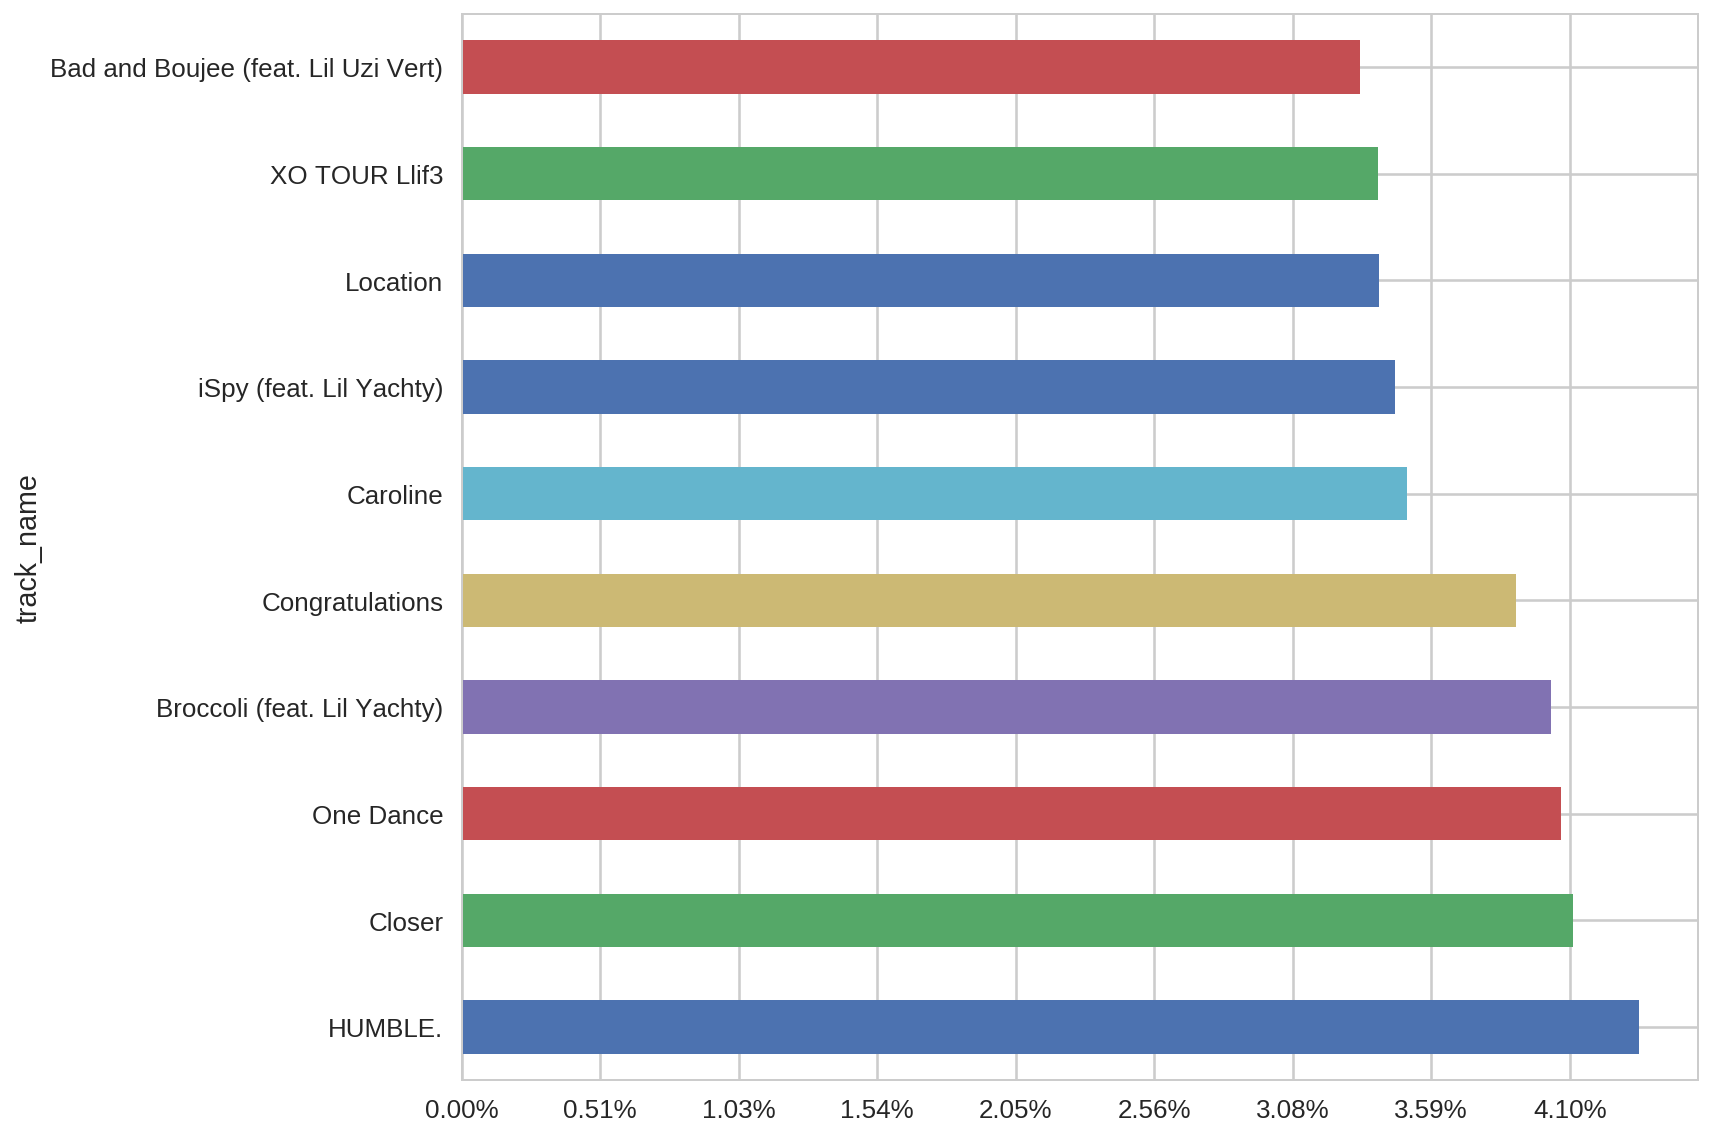

In [9]:
pop_tracks = tracks2[['pid','track_uri']].drop_duplicates()
track_names = tracks2[['track_name','track_uri']].drop_duplicates()
pop_tracks = pd.DataFrame(pop_tracks['track_uri'].value_counts()[:10]).reset_index().rename(columns = {'index':'track_uri',
                                                                                              'track_uri':'count'})
pop_tracks = pd.merge(pop_tracks, track_names, on = 'track_uri').set_index('track_name')
ax = pop_tracks['count'].plot(kind='barh', figsize= (12,8))

vals = ax.get_xticks()
vals = vals/num_playlists
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.tight_layout()

### Most Popular Songs in each Decade

No handles with labels found to put in legend.


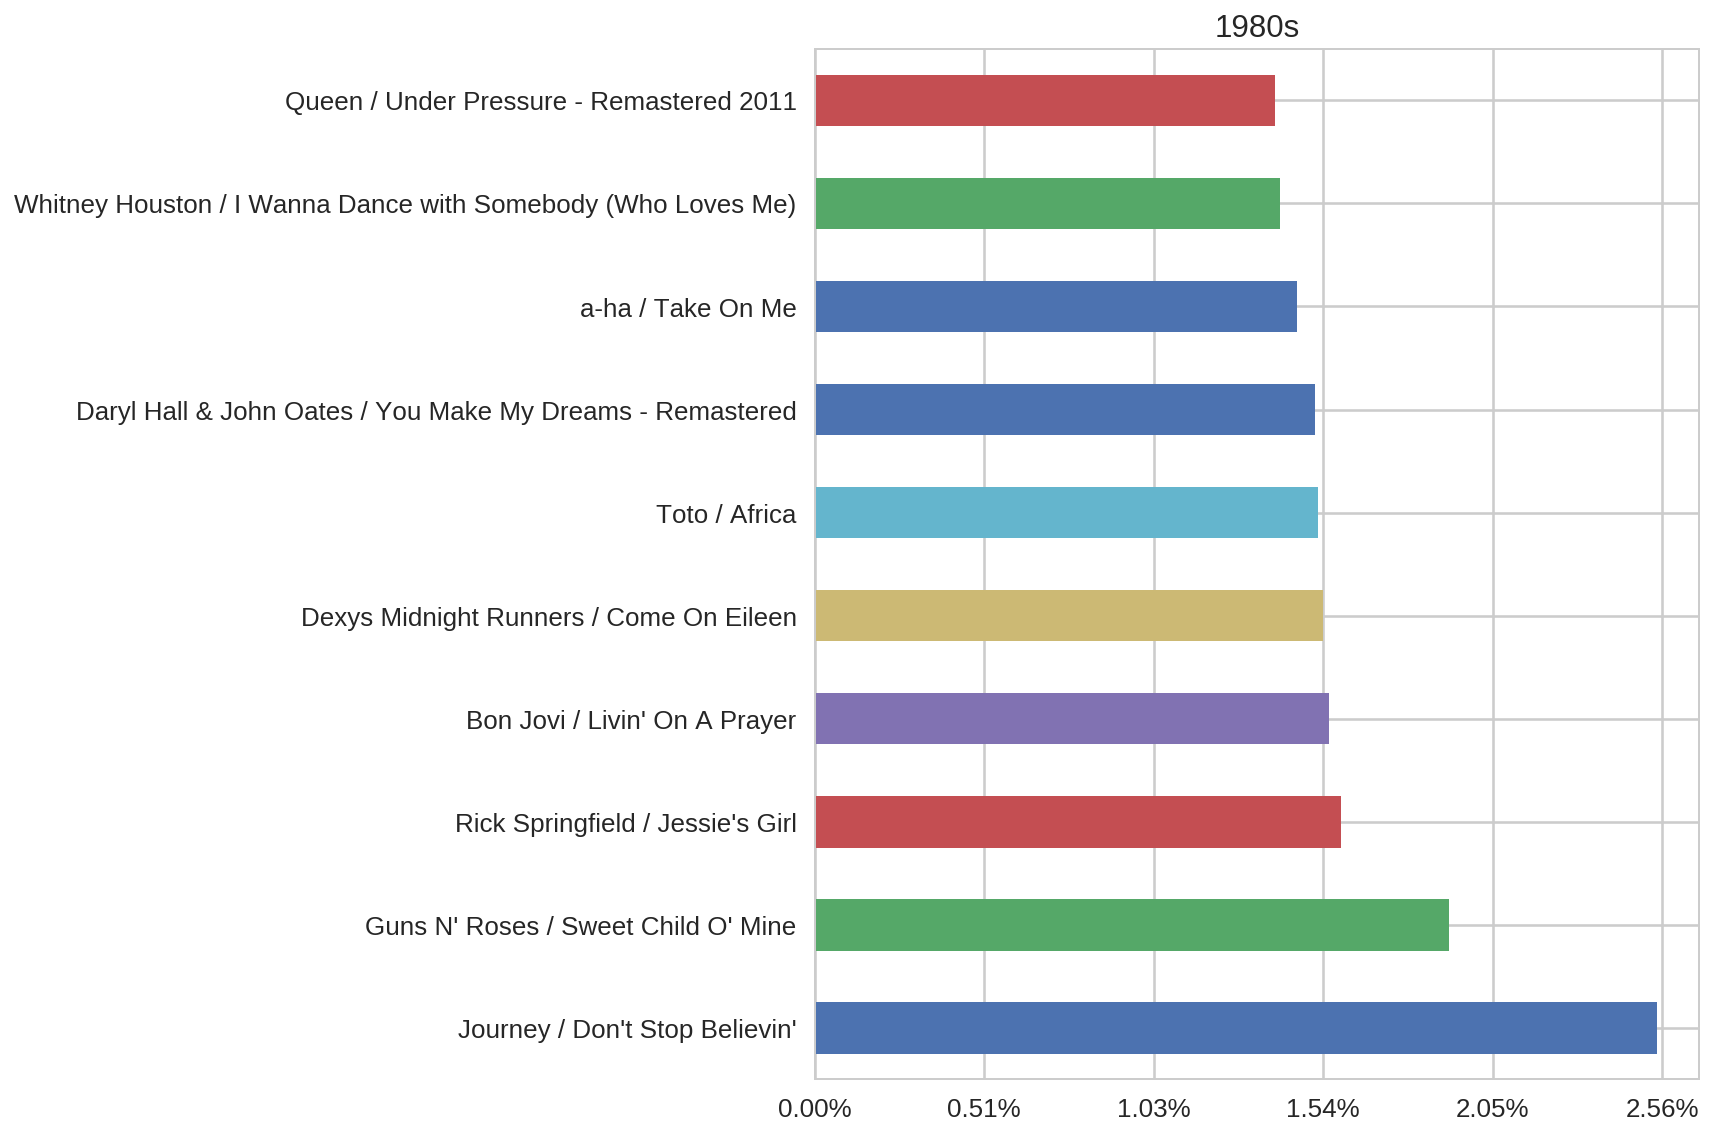

In [10]:
plt.legend(loc='best')
plt.tight_layout()

tracks2['artist_track'] = tracks2['artist_name'] + ' / ' + tracks2['track_name']

tracks_80s = tracks2[tracks2.decade == 1980][['pid','artist_track']]
ax = tracks_80s['artist_track'].value_counts()[:10].plot(kind = 'barh', figsize= (12,8))
ax.set_title('1980s')

vals = ax.get_xticks()
vals = vals/num_playlists
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.tight_layout()

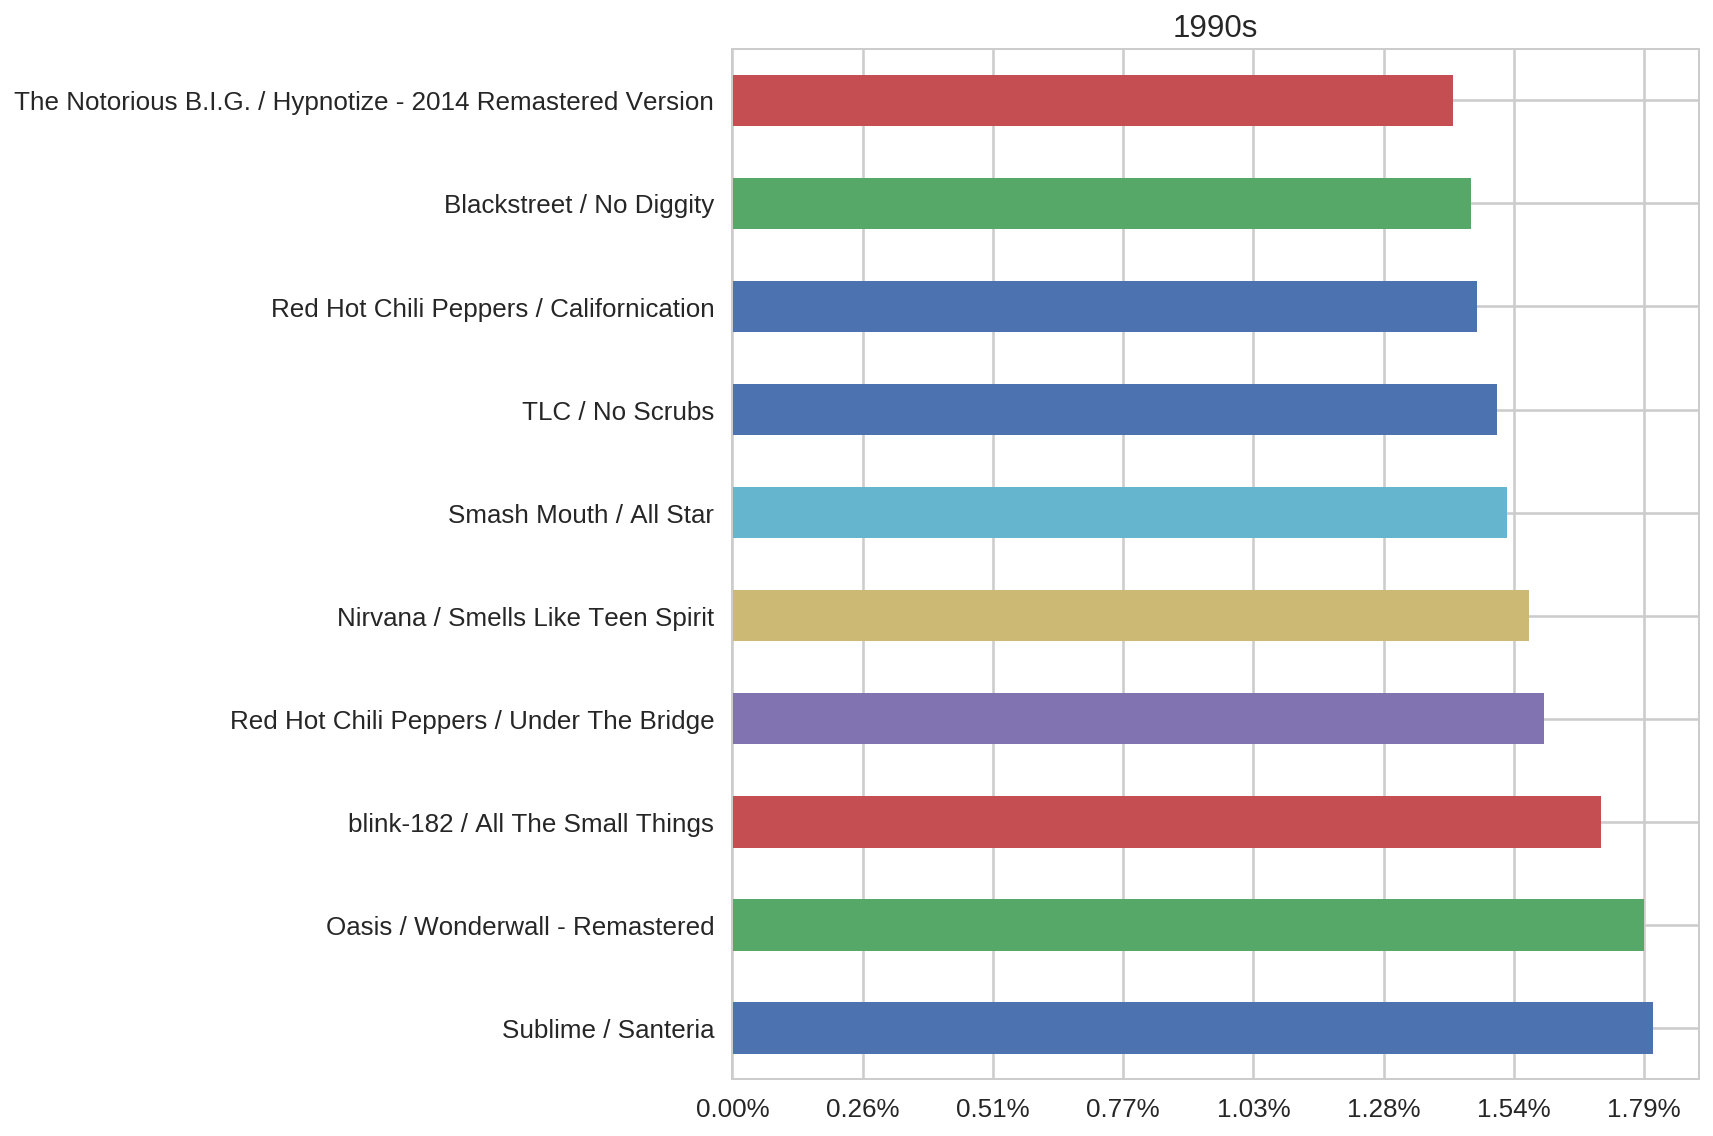

In [11]:
tracks_90s = tracks2[tracks2.decade == 1990][['pid','artist_track']]
ax = tracks_90s['artist_track'].value_counts()[:10].plot(kind = 'barh', figsize= (12,8))
ax.set_title('1990s')

vals = ax.get_xticks()
vals = vals/num_playlists
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.tight_layout()

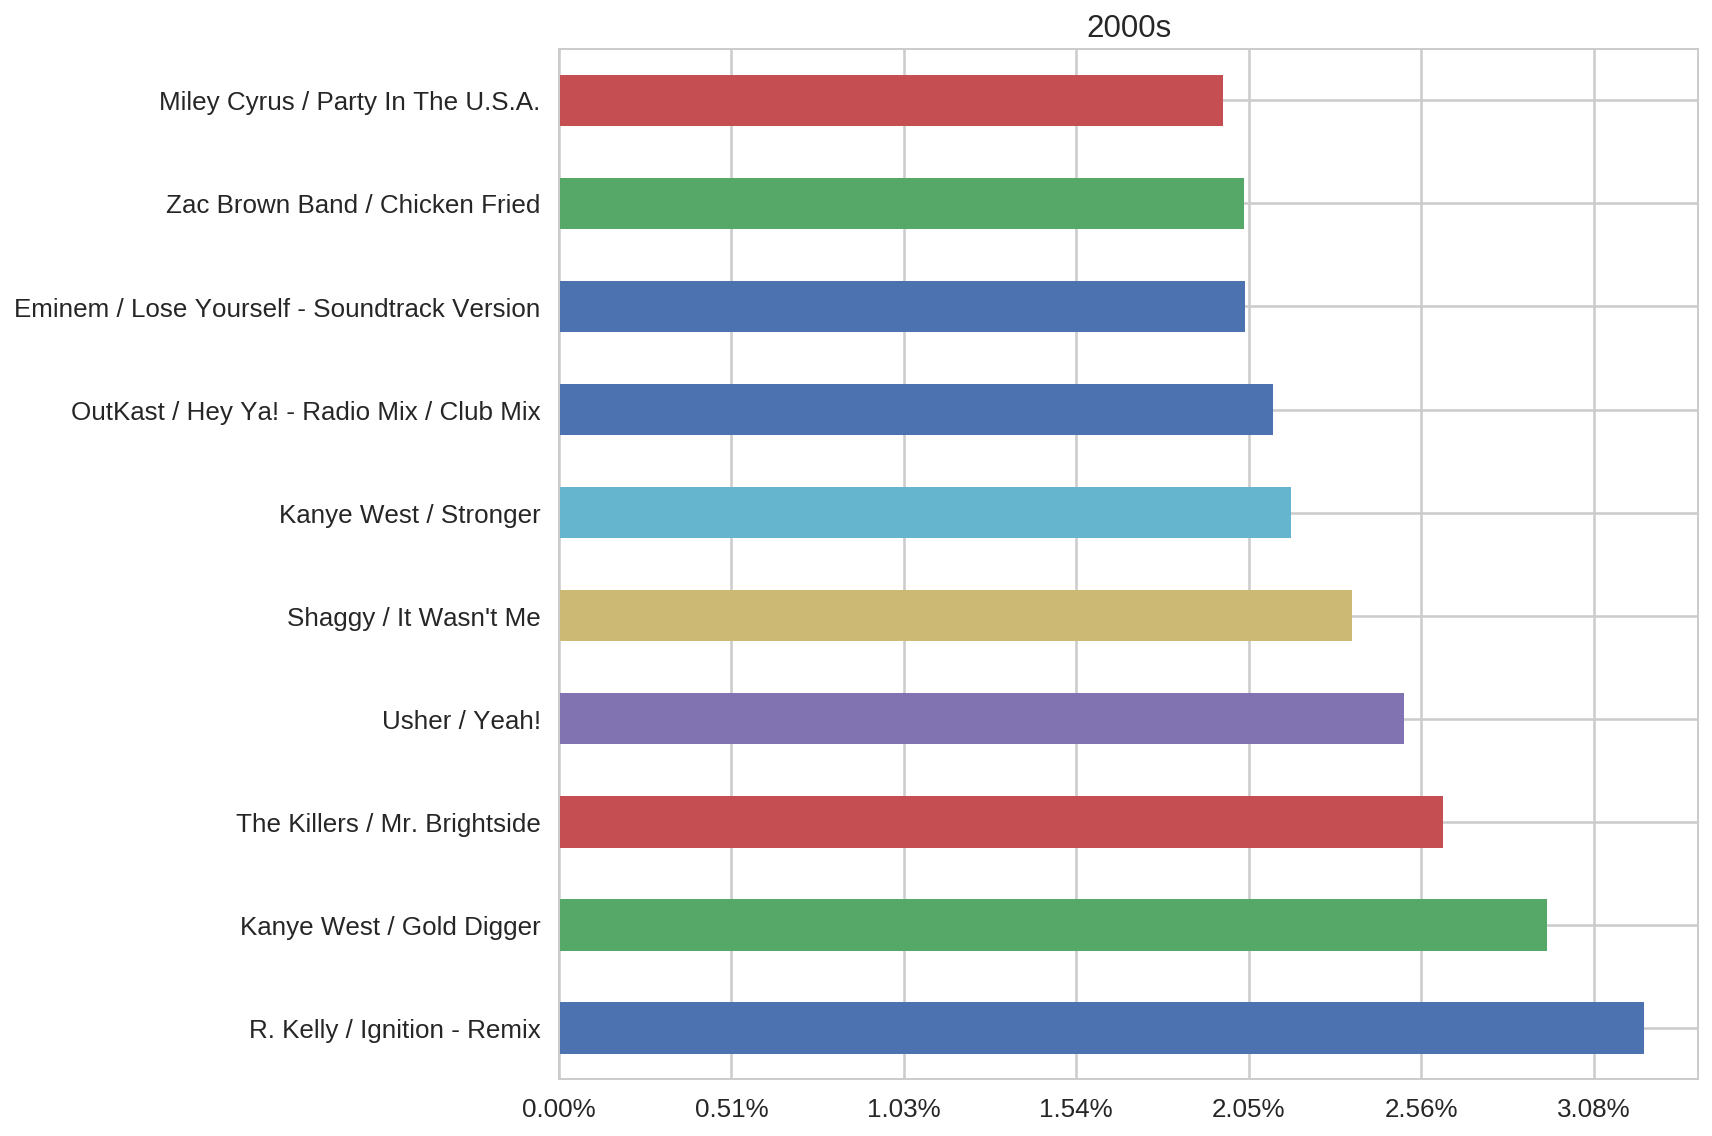

In [33]:
tracks_00s = tracks2[tracks2.decade == 2000][['pid','artist_track']]
ax = tracks_00s['artist_track'].value_counts()[:10].plot(kind = 'barh', figsize= (12,8))
ax.set_title('2000s')

vals = ax.get_xticks()
vals = vals/num_playlists
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals])
plt.tight_layout()

## Correlation of dance metrics

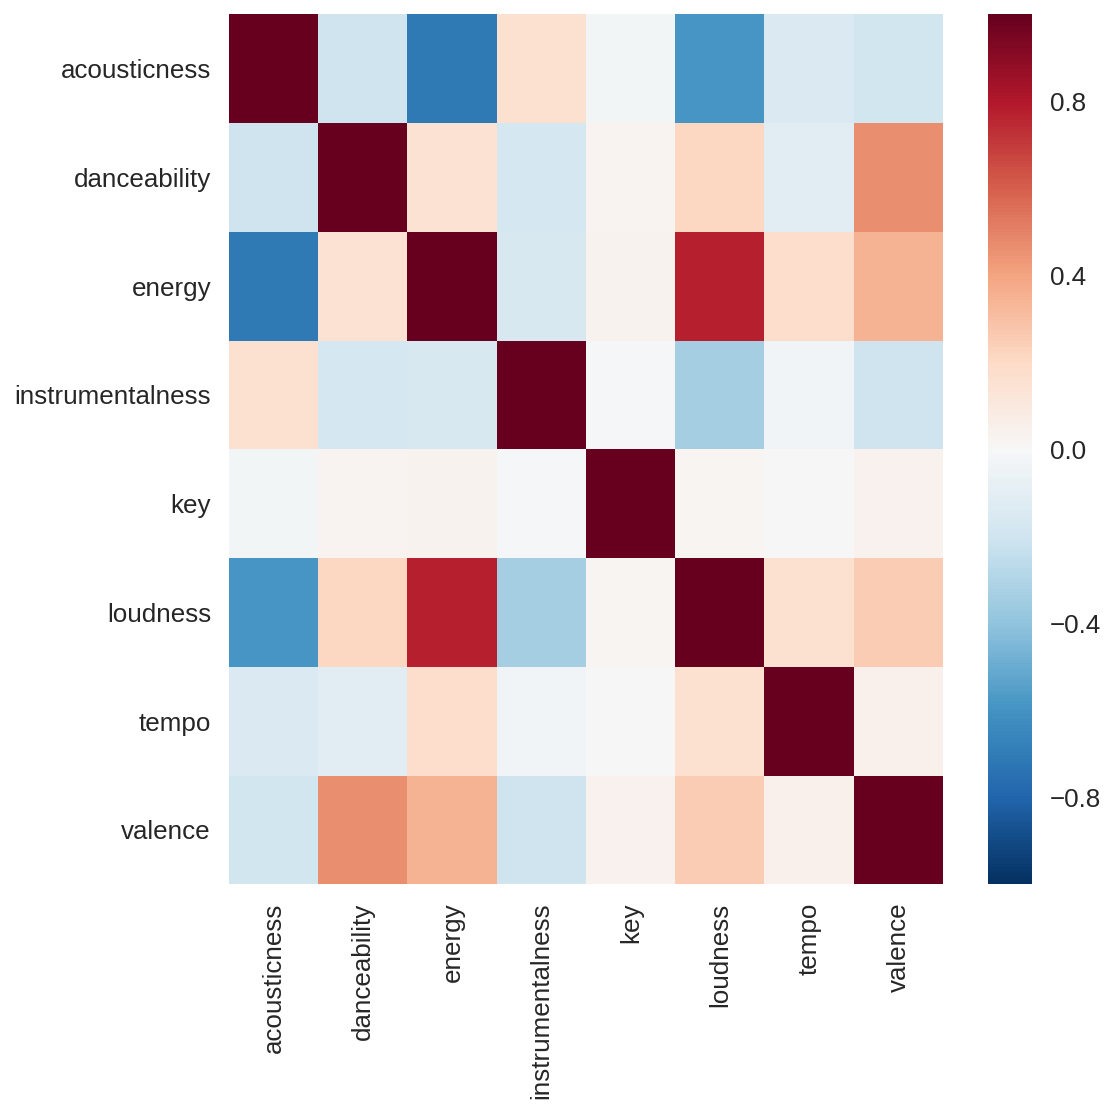

In [22]:
corr_features = track_features.set_index('track_uri').corr()
#corr_features
fig, ax = plt.subplots(figsize=(8,8)) 
sns.heatmap(corr_features)

## Get Lyrics

In [0]:
## Calculate the main genre for the sub_genres

def calc_main_genre(row):
  if not isinstance(row['genres'], str):
    return 'empty'
  elif 'rap' in row['genres'] or 'hip hop' in row['genres'] or 'trap' in row['genres']:
    return 'hip hop'
  elif 'pop' in row['genres']:
    return 'pop'
  elif 'rock' in row['genres'] or 'punk' in row['genres'] or 'metal' in row['genres'] or 'indie' in row['genres']:
    return 'rock'
  elif 'edm' in row['genres'] or 'room' in row['genres'] or 'house' in row['genres'] or 'dance' in row['genres']:
    return 'edm'
  elif 'country' in row['genres']:
    return 'country'
  elif 'emo' in row['genres']:
    return 'emo'
  else:
    return 'other'

genres = tracks2[['track_uri','genres']].drop_duplicates()
genres['main_genre'] = genres.apply(calc_main_genre, axis = 1)

pop_tracks = tracks2[['pid','track_uri', 'track_name']].drop_duplicates()
top_tracks = pd.merge(pop_tracks, genres, on = ['track_uri'])

top_50_tracks = top_tracks.groupby(['track_uri','main_genre'])['pid'].count().reset_index().sort_values(['main_genre','pid'],ascending = False)
top_50_tracks = top_50_tracks.groupby('main_genre').head(50)
top_50_tracks = top_50_tracks[(top_50_tracks.main_genre != 'other') & (top_50_tracks.main_genre != 'empty')]



In [143]:
#Install lyricwikia API
!pip install lyricwikia
import lyricwikia

##Get lyrics for the top 1000 songs

artist_tracks = tracks2[['artist_name','track_name', 'track_uri']].drop_duplicates()
artist_tracks = artist_tracks[artist_tracks.track_uri.isin(top_50_tracks.track_uri)]

def get_lyrics(row):
  try:
    return lyricwikia.get_lyrics(row['artist_name'], row['track_name'])
  except:
    return ' '                         

artist_tracks['lyrics'] = artist_tracks.apply(get_lyrics, axis=1)

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
edm


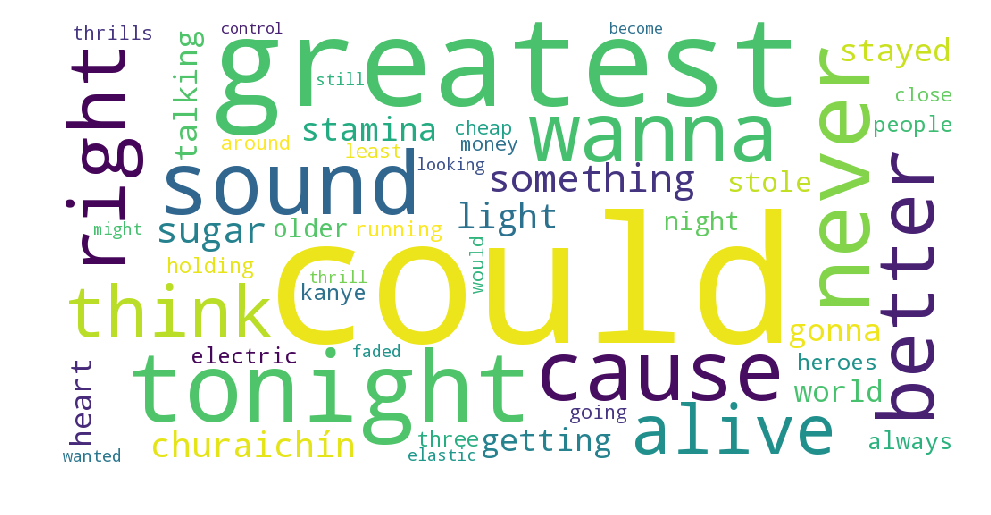

pop


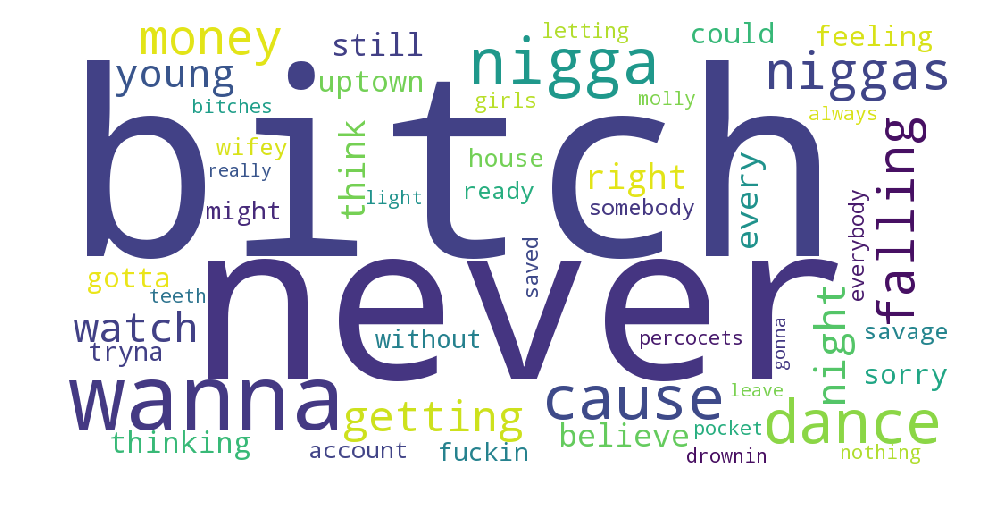

rock


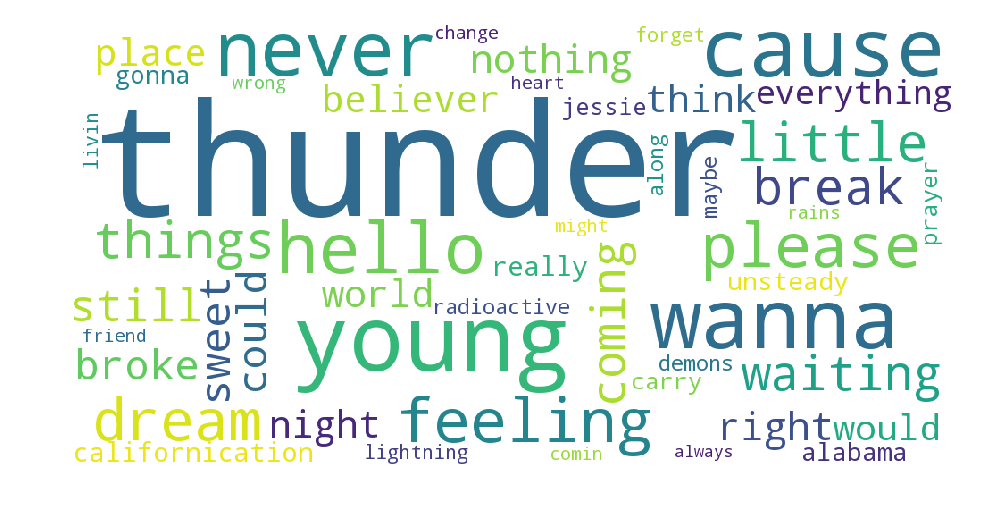

hip hop


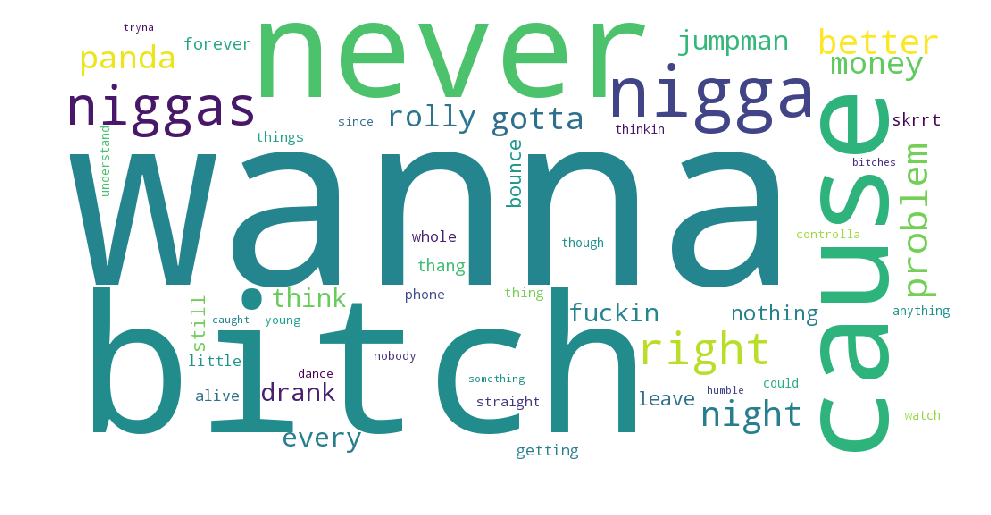

country


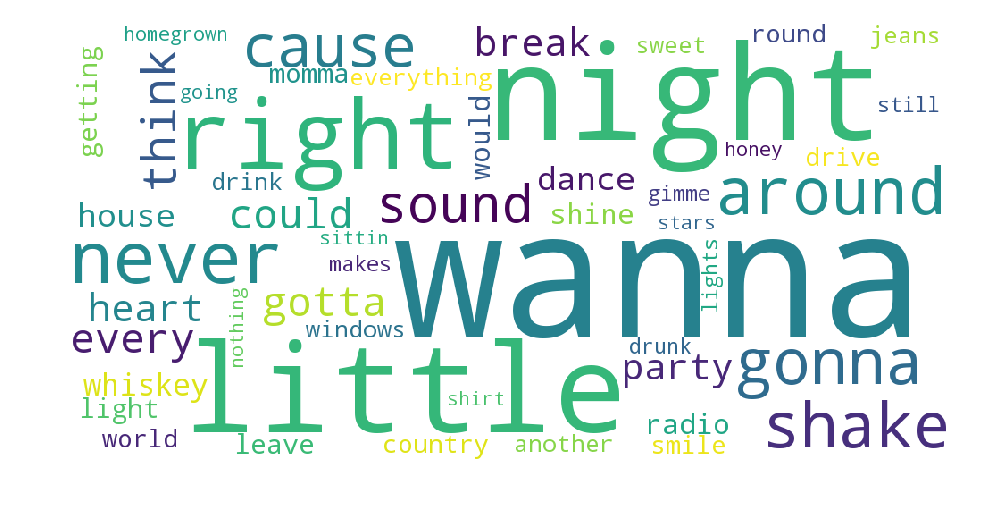

In [146]:
#Generate wordcloud for the top 50 words in each genre. Remove stop words

!pip install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


artist_tracks2 = artist_tracks[artist_tracks.lyrics != ' '] # Remove tracks that dont have lyrics

artist_tracks2 = pd.merge(artist_tracks2, top_50_tracks,on = 'track_uri')

main_genres = set(artist_tracks2['main_genre'].tolist())

for genre in main_genres:
  print(genre)
  
  text = artist_tracks2[artist_tracks2['main_genre'] == genre].lyrics.tolist()

  # Count the number of times each word appears
  vectorizer = CountVectorizer()
  vectorizer.fit(text)
  vector = vectorizer.transform(text)

  freqs = dict(zip(vectorizer.get_feature_names(), vector.toarray().sum(axis=0)))


  # Remove stop words. These are the prepositions, pronouns etc
  stop_words = set(stopwords.words('english'))
  all_words = list(freqs.keys())
  for word in all_words:
    if word in stop_words:
      freqs.pop(word, None)
    elif len(word) < 5:
      freqs.pop(word, None)

  most_popular = dict(sorted(freqs.items(), key=lambda x: -x[1])[:50])

  def generate_wordcloud(most_popular): 
      wordcloud = WordCloud(width = 1000, height = 500,
                            relative_scaling = 1.0, background_color='white'
                            )
      wordcloud.generate_from_frequencies(most_popular)
      plt.imshow(wordcloud)
      plt.axis("off")
      plt.show()
      #plt.title(genre)

  generate_wordcloud(most_popular)


## Predicting if I will like a song or not

In [25]:
tracks_I_like = pd.read_csv('https://www.dropbox.com/s/o4kr73nhqvhja0m/tracks_i_like.csv?dl=1')

tracks_I_like = pd.merge(tracks_I_like, track_features,on = 'track_uri', how = 'left')
tracks_I_like = pd.merge(tracks_I_like, tracks2[['release_year','track_uri']].drop_duplicates(),on = 'track_uri', how = 'left')
tracks_I_like = pd.merge(tracks_I_like, tracks2[['popularity_y','track_uri']].drop_duplicates(),on = 'track_uri', how = 'left')
tracks_I_like.head()


,Like,track_uri,main_genre,pid,artist_name,track_name,acousticness,danceability,energy,instrumentalness,key,loudness,tempo,valence,release_year,popularity_y
0,0,spotify:track:152lZdxL1OR0ZMW6KquMif,rock,3311,Khalid,Location,0.33000,0.736,0.449,0.000162,1.0,-11.462,80.126,0.326,2017,94.0
1,1,spotify:track:7oK9VyNzrYvRFo7nQEYkWN,rock,2528,The Killers,Mr. Brightside,0.00108,0.330,0.936,0.000000,1.0,-3.660,148.112,0.234,2004,81.0
2,1,spotify:track:4bHsxqR3GMrXTxEPLuK5ue,rock,2403,Journey,Don't Stop Believin',0.12700,0.500,0.748,0.000000,4.0,-9.072,118.852,0.514,1981,75.0
3,0,spotify:track:12REd1n8PeiHHWOh066tpr,rock,2262,Flume,Never Be Like You,0.43600,0.494,0.559,0.000000,0.0,-5.445,119.247,0.264,2016,75.0
4,1,spotify:track:1AhDOtG9vPSOmsWgNW0BEY,rock,2236,Queen,Bohemian Rhapsody - Remastered 2011,0.27100,0.414,0.404,0.000000,0.0,-9.928,71.105,0.224,1975,85.0


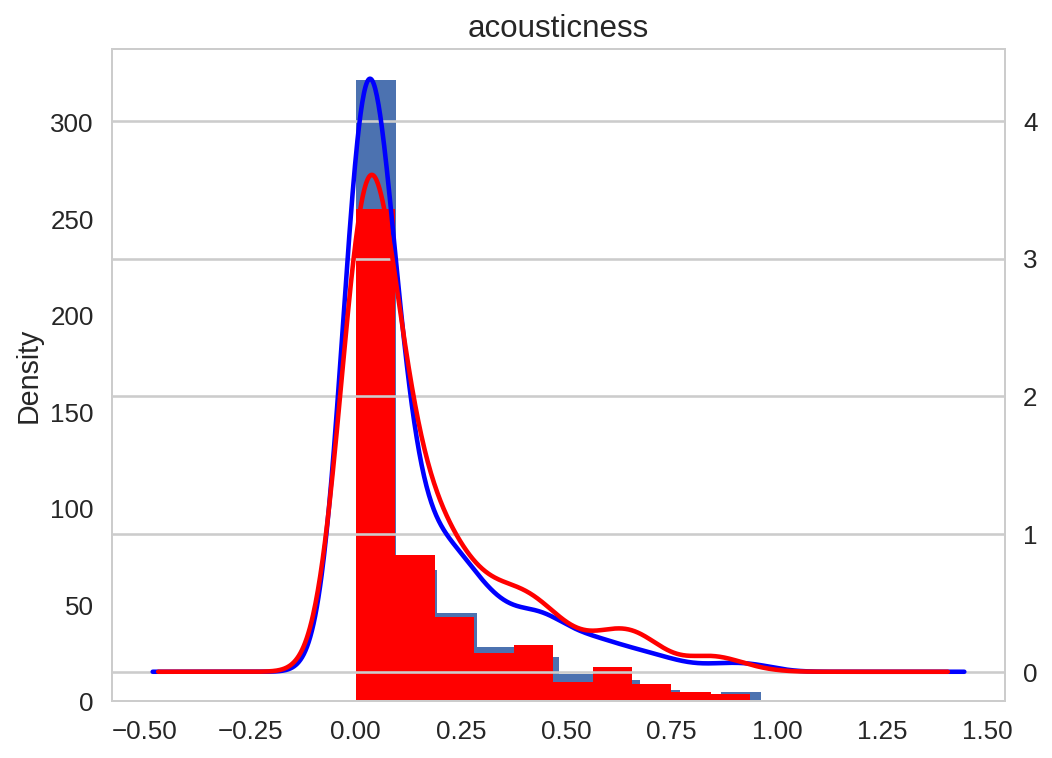

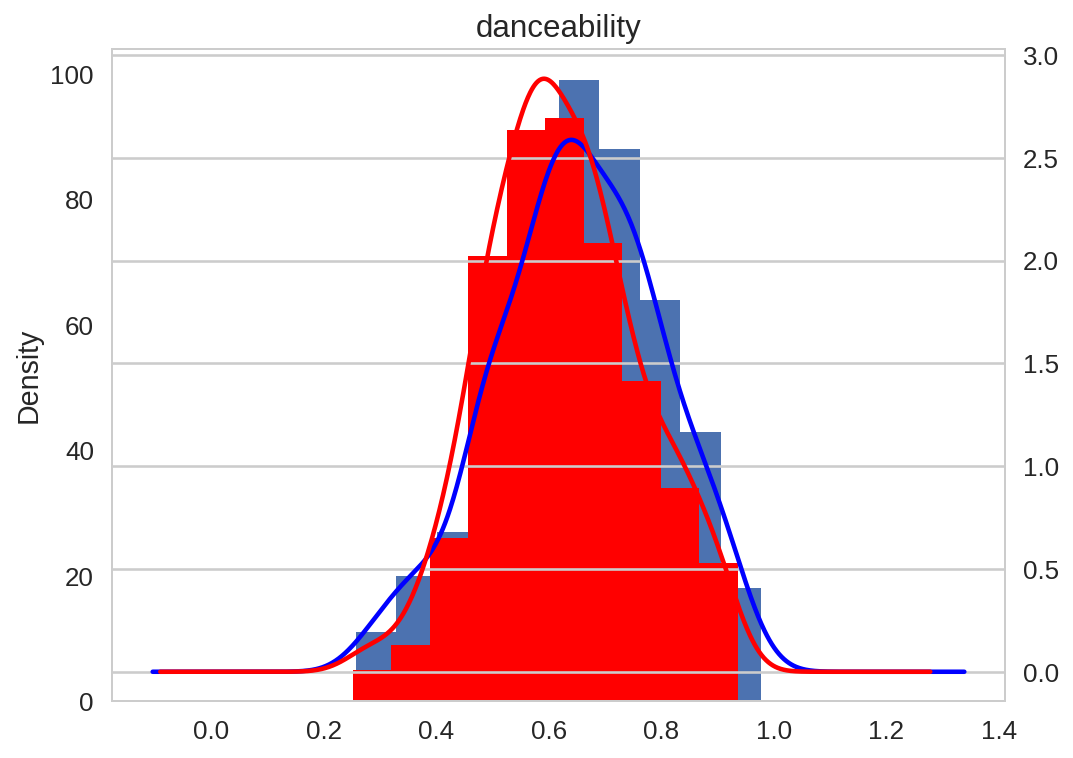

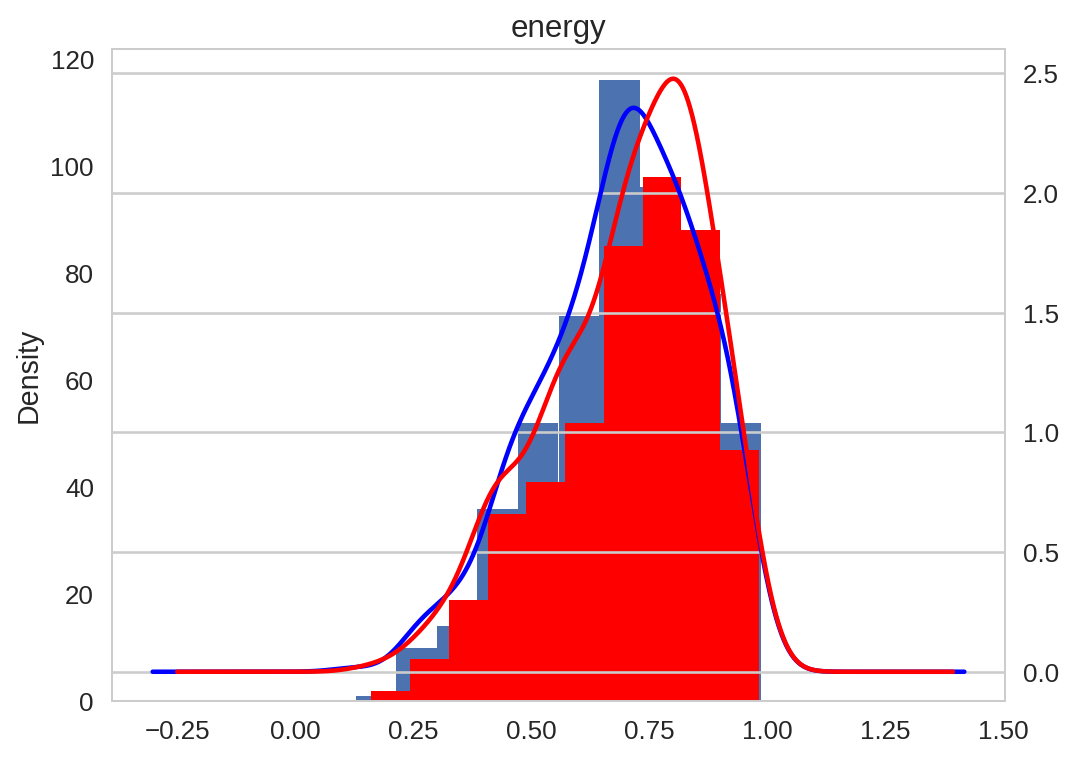

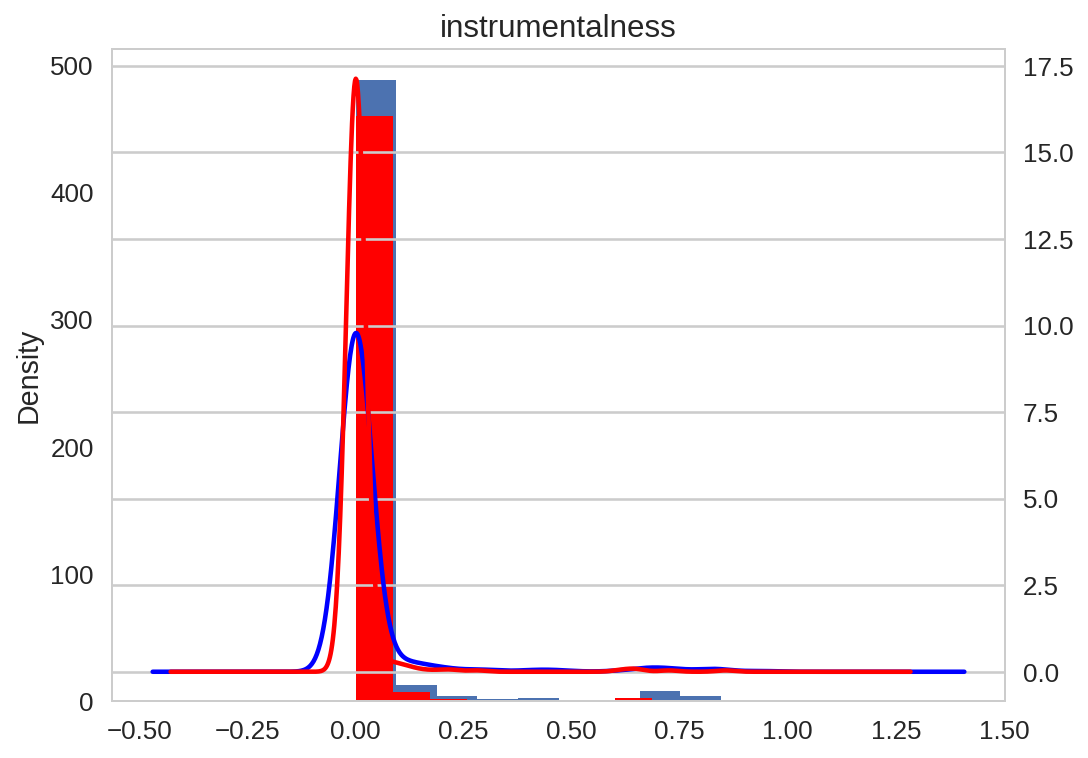

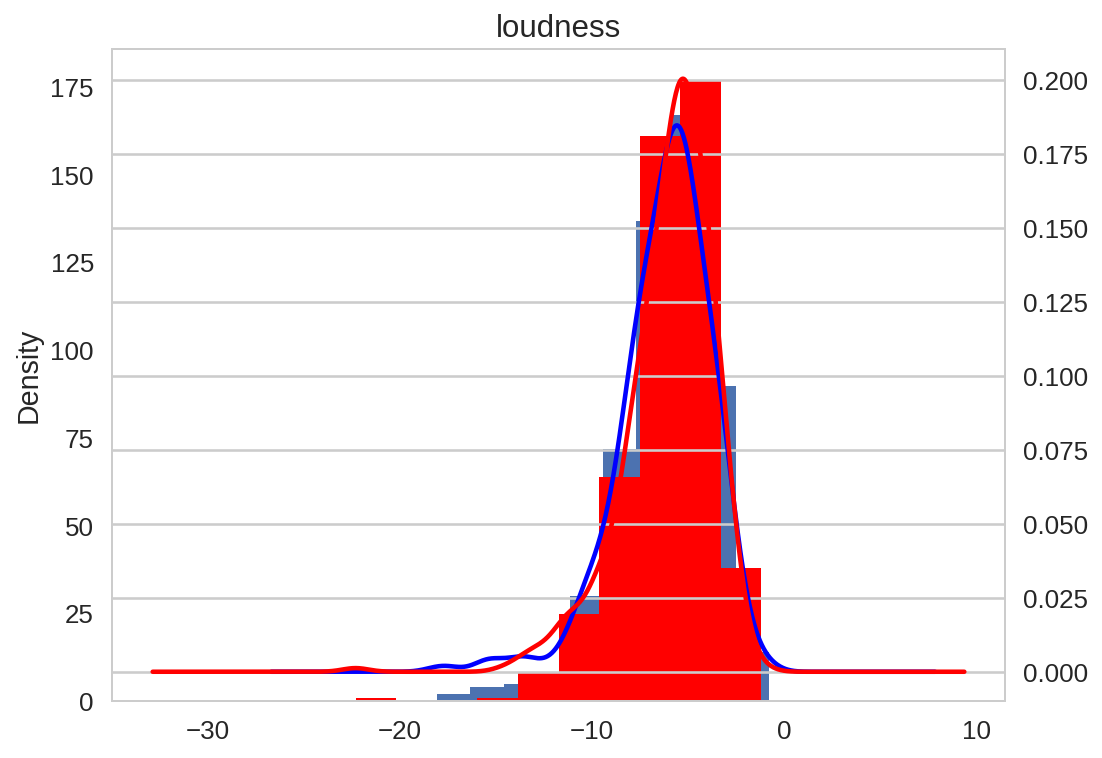

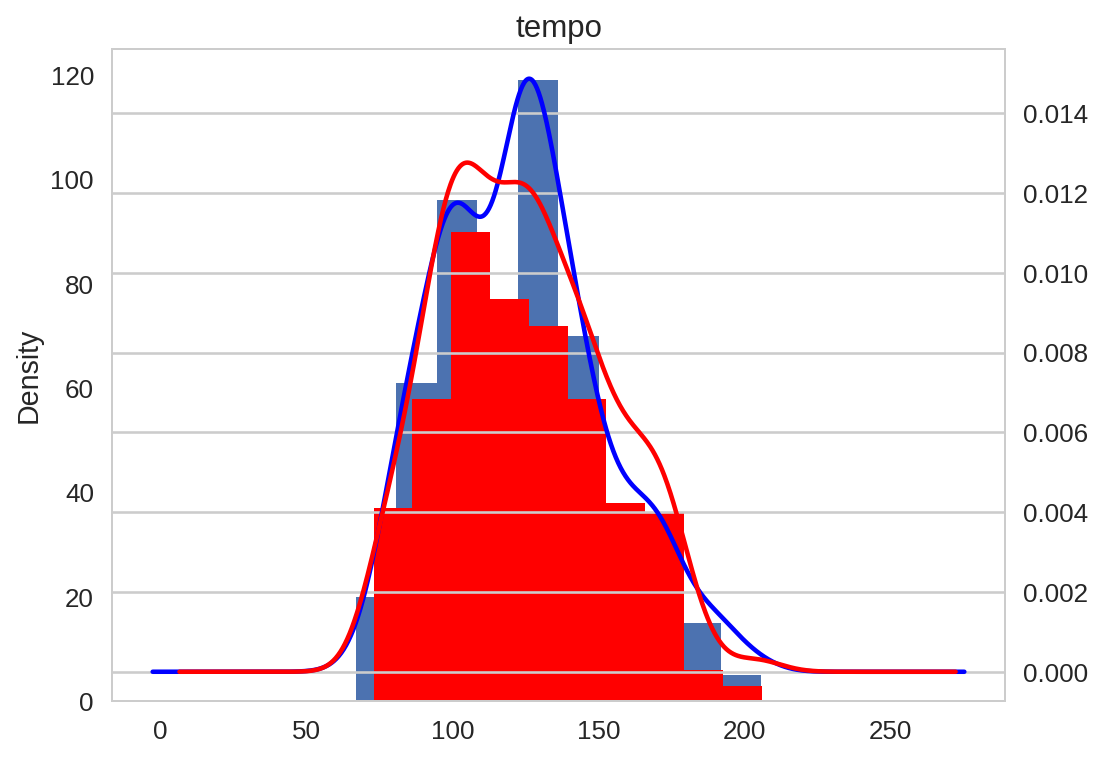

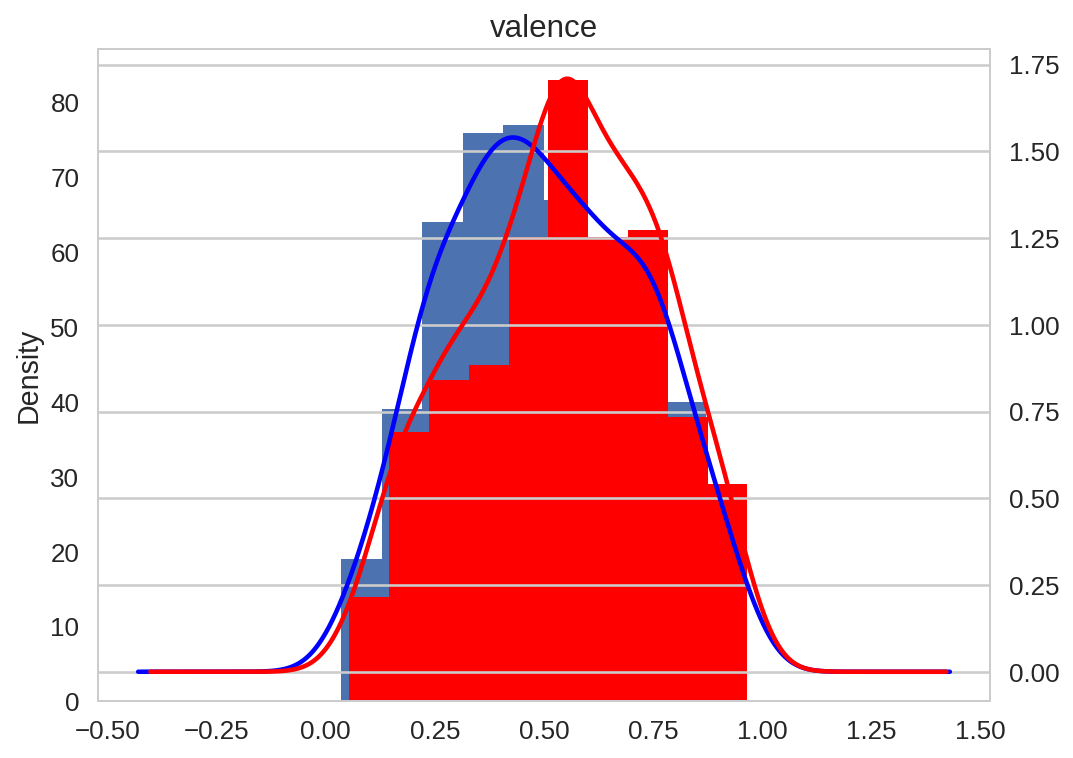

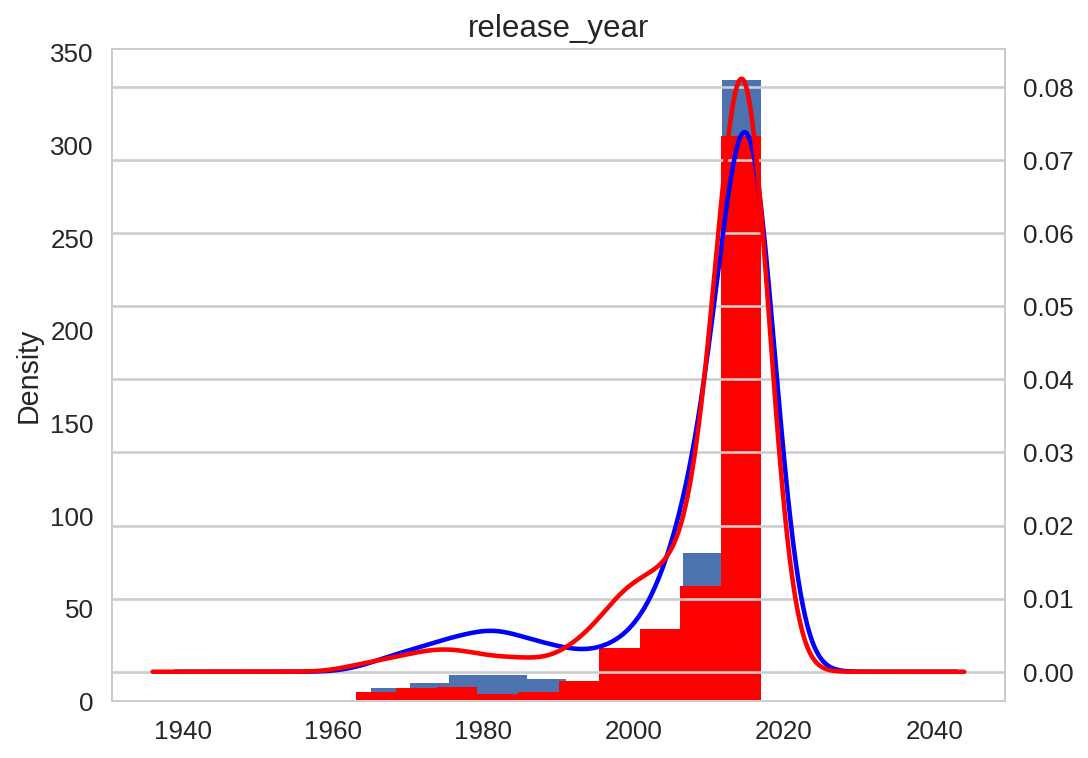

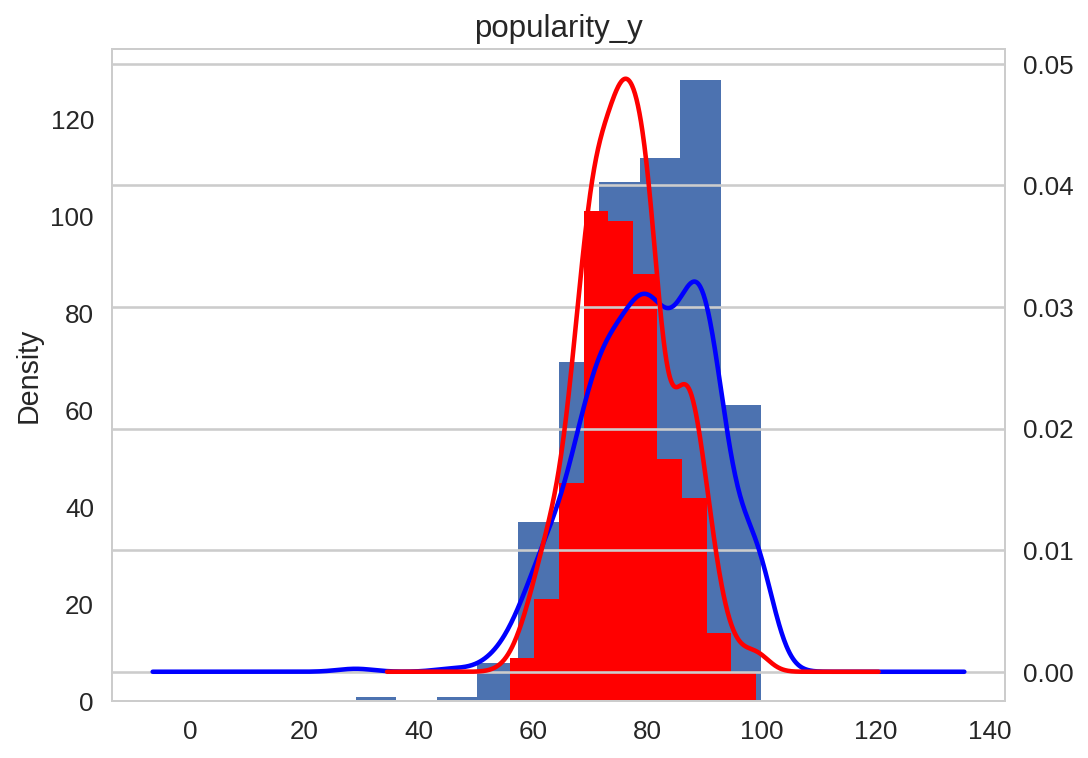

In [27]:
dets = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'tempo', 'valence', 'release_year', 'popularity_y']
for metric in dets:
  ax = tracks_I_like[tracks_I_like['Like'] == 1][[metric]].plot(kind='hist', figsize = (8,6))
  tracks_I_like[tracks_I_like['Like'] == 0][[metric]].plot(kind='hist', figsize = (8,6), ax = ax, color = 'red')
  tracks_I_like[tracks_I_like['Like'] == 1][[metric]].plot(kind='kde', figsize = (8,6), ax = ax, secondary_y=True, color = 'blue')
  tracks_I_like[tracks_I_like['Like'] == 0][[metric]].plot(kind='kde', figsize = (8,6), ax = ax, color = 'red', secondary_y=True)
  ax.set_title(metric)
  ax.legend_.remove()

In [32]:
## USing logistic regression for prediction

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix 

from sklearn.neighbors import KNeighborsClassifier 

import statsmodels.api as sm

x_var = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'valence', 'release_year', 'popularity_y']

x = tracks_I_like[x_var]
y = tracks_I_like[['Like']]

logisticRegr = LogisticRegression()

rfe = RFE(logisticRegr, 18)
rfe = rfe.fit(x,y )
#print(rfe.support_)
#print(rfe.ranking_)

X_train, X_test, Y_train, Y_test = train_test_split(x, 
                                                    y, test_size=0.10, random_state=0)

scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

## LOGISTIC REGRESSION

import statsmodels.api as sm
logit = sm.Logit(y, x)

# fit the model
result = logit.fit()
print(result.summary())


logisticRegr.fit(X_train, Y_train)

y_pred = logisticRegr.predict(X_test)
#print(X_test)

#print(confusion_matrix(Y_test, y_pred))  
#print(classification_report(Y_test, y_pred)) 
#print(len(y_pred))

y_pred = logisticRegr.predict(ex1[x_var].values)
y_pred2 = logisticRegr.predict(ex2[x_var].values)
#print(ex1[x_var].values, y_pred)
#print(y_pred2)
#print(len(x))



'''
## K NEAREST NEIGHBORS
classifier = KNeighborsClassifier(n_neighbors=17)  
classifier.fit(X_train, Y_train)  

y_pred = classifier.predict(X_test)  

print(confusion_matrix(Y_test, y_pred))  
print(classification_report(Y_test, y_pred))  

 
#print(confusion_matrix(Y_test, y_pred))  
#print(classification_report(Y_test, y_pred))  
error = []
# Calculating error for K values between 1 and 40
for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    #print(pred_i,Y_test['Like'])
    error.append(np.mean(pred_i != Y_test['Like'].tolist()))

    
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  
'''


Optimization terminated successfully.
         Current function value: 0.658977
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   Like   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      993
Method:                           MLE   Df Model:                            6
Date:                Wed, 27 Jun 2018   Pseudo R-squ.:                 0.04758
Time:                        16:06:47   Log-Likelihood:                -658.98
converged:                       True   LL-Null:                       -691.90
                                        LLR p-value:                 2.906e-12
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
acousticness        -0.6029      0.392     -1.540      0.124      -1.370       0.164
danceabilit

"\n## K NEAREST NEIGHBORS\nclassifier = KNeighborsClassifier(n_neighbors=17)  \nclassifier.fit(X_train, Y_train)  \n\ny_pred = classifier.predict(X_test)  \n\nprint(confusion_matrix(Y_test, y_pred))  \nprint(classification_report(Y_test, y_pred))  \n\n \n#print(confusion_matrix(Y_test, y_pred))  \n#print(classification_report(Y_test, y_pred))  \nerror = []\n# Calculating error for K values between 1 and 40\nfor i in range(1, 40):  \n    knn = KNeighborsClassifier(n_neighbors=i)\n    knn.fit(X_train, y_train)\n    pred_i = knn.predict(X_test)\n    #print(pred_i,Y_test['Like'])\n    error.append(np.mean(pred_i != Y_test['Like'].tolist()))\n\n    \nplt.figure(figsize=(12, 6))  \nplt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  \n         markerfacecolor='blue', markersize=10)\nplt.title('Error Rate K Value')  \nplt.xlabel('K Value')  \nplt.ylabel('Mean Error')  \n"

## Track Features

### Genres By TIme

In [8]:
# Get genres and decades for each playlist
df_gy = tracks2[['pid', 'genres', 'decade']].drop_duplicates()

# eliminate decades before 1970
df_gy = df_gy[df_gy.decade >= 1970]

In [9]:
df_gy['main_genre'] = df_gy.apply(calc_main_genre, axis=1)
df_gy.head()

,pid,genres,decade,main_genre
0,1000,broadway,2000,other
1,18141,broadway,2000,other
2,24684,broadway,2000,other
3,44565,broadway,2000,other
4,58137,broadway,2000,other


In [10]:
# delete values that have empty main_genre
df_gy = df_gy.drop(df_gy[df_gy.main_genre == 'empty'].index)

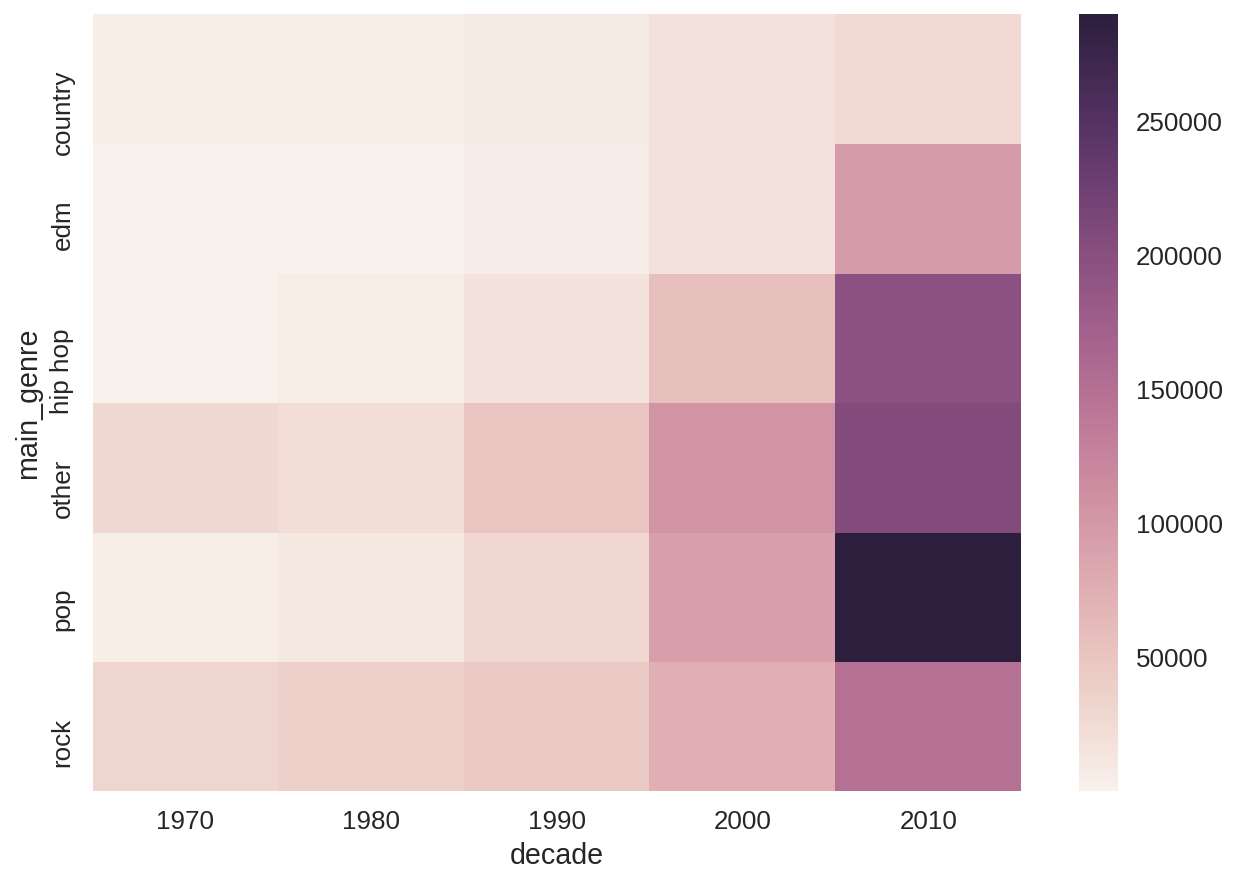

In [11]:
# Genres and year in heatmap
pivot_gy = pd.pivot_table(
    data = df_gy, 
    index = 'decade', # specifies the rows
    columns = 'main_genre',
    values = 'pid',  # specifies the content of the cells
    aggfunc = 'count', # we ask to count how many different CAMIS values we see,
    fill_value = 0
)


ax = sns.heatmap(pivot_gy.T)

In [12]:
# Get genres and year for each playlist in the last 10 years
df_gy_2 = tracks2[['pid', 'genres', 'release_year']].drop_duplicates()

# eliminate decades before 1970
df_gy_2 = df_gy_2[df_gy_2.release_year >= 2007]
df_gy_2.release_year = df_gy_2.release_year.astype(int)

In [13]:
df_gy_2['main_genre'] = df_gy_2.apply(calc_main_genre, axis=1)
df_gy_2.head()

,pid,genres,release_year,main_genre
0,1000,broadway,2008,other
1,18141,broadway,2008,other
2,24684,broadway,2008,other
3,44565,broadway,2008,other
4,58137,broadway,2008,other


In [14]:
df_gy_2 = df_gy_2.drop(df_gy_2[df_gy_2.main_genre == 'empty'].index)

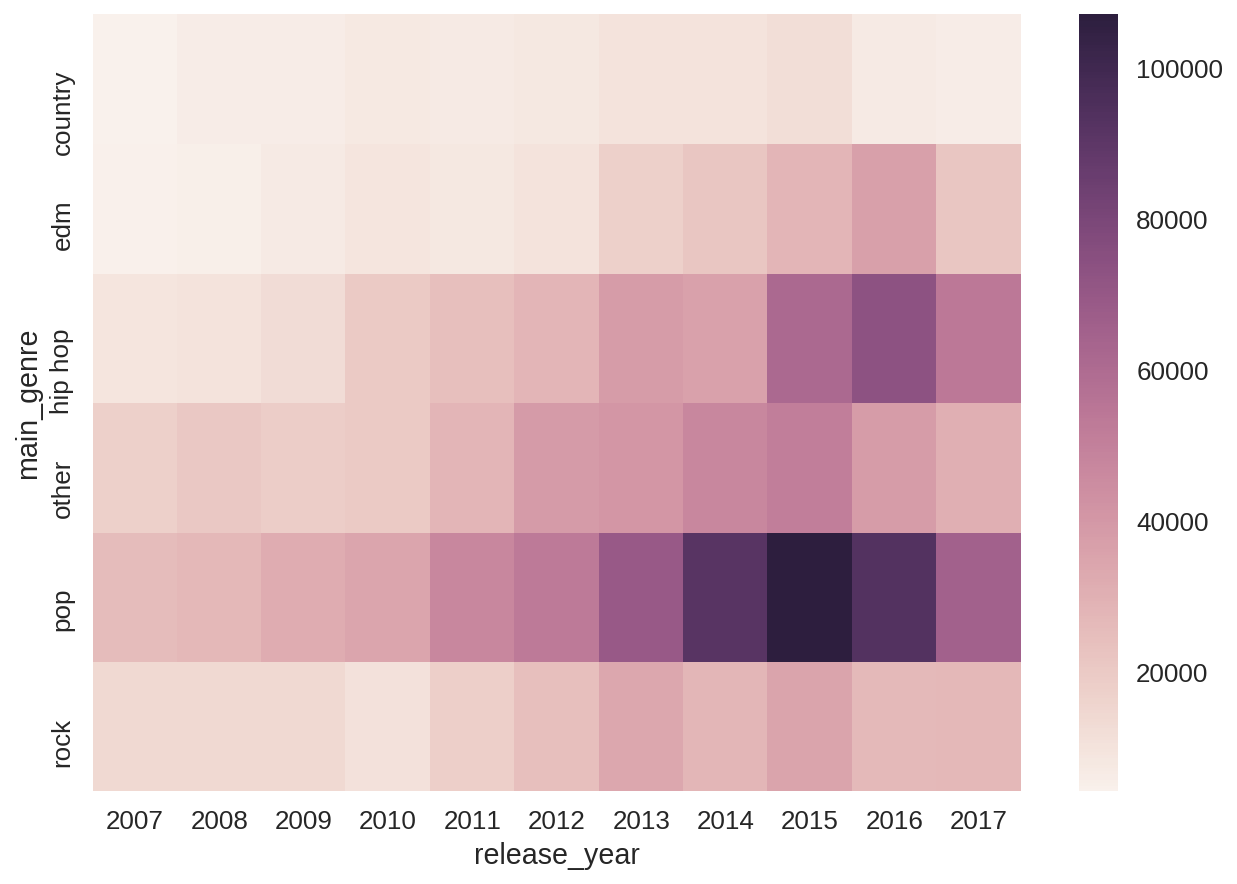

In [15]:
# Genres and year in heatmap
pivot_gy_2 = pd.pivot_table(
    data = df_gy_2, 
    index = 'release_year', # specifies the rows
    columns = 'main_genre',
    values = 'pid',  # specifies the content of the cells
    aggfunc = 'count', # we ask to count how many different CAMIS values we see,
    fill_value = 0
)


ax = sns.heatmap(pivot_gy_2.T)

### Genres by duration

In [16]:
# Get duration and genres
df_gd = tracks2[['duration_ms', 'genres', 'track_uri']]
df_gd['duration_s'] = df_gd['duration_ms']/1000
df_gd.drop('duration_ms', axis=1, inplace=True)
df_gd = df_gd.drop_duplicates()

In [17]:
df_gd['main_genre'] = df_gd.apply(calc_main_genre, axis=1)
df_gd.head()

,genres,track_uri,duration_s,main_genre
0,broadway,spotify:track:6rKVAvjHcxAzZ1BHtwh5yC,79.066,other
6,broadway,spotify:track:0ABxAcsRWlqckkyONsfP67,297.920,other
15,NaN,spotify:track:1iVkEiZS6ijZ76KeMsrXG6,204.573,empty
52,broadway,spotify:track:2jxJF5RaHcqcUyg3T3FHpW,122.813,other
63,broadway,spotify:track:5eHx8TOZ7UIQLtd6aUWKkK,219.640,other


In [18]:
# delete empty main_genre
df_gd = df_gd.drop(df_gd[df_gd.main_genre == 'empty'].index)

In [30]:
# remove tracks that skew results
df_gd = df_gd.drop(df_gd[df_gd.duration_s > 600].index)

In [28]:
df_gd.sort_values(by='duration_s', ascending=False).head(10)

,genres,track_uri,duration_s,main_genre
5103663,dance pop,spotify:track:3R0dnuJCoEGyowPyBBERrO,1694.906,pop
4031505,soundtrack,spotify:track:3x0u0TFu2JoGUIERBEd2Lv,1691.320,other
5512427,bebop,spotify:track:4IqzVeWfWLPQ2deCYYWeXL,1618.693,other
2083591,pop,spotify:track:1H2KZ21IWEEhjoVyqS10S8,1549.965,pop
3725060,chamber pop,spotify:track:5CLs0uFRmU0U9VcnsI6jwv,1534.720,pop
5235790,classical,spotify:track:6IQ1XK96ipPTqlEXCPYWwR,1504.800,other
5245702,sleep,spotify:track:3YMOXCsCYZTSdGMOZz8SzI,1440.027,other
5355854,classical,spotify:track:5rBYEpU6YrWnnig9UM23du,1434.040,other
4453542,album rock,spotify:track:1Mzm1CNqVxtwbCYhOo843s,1412.451,rock
5131759,movie tunes,spotify:track:5H5P9DB1WI9VIwYG0Z79gh,1361.120,other


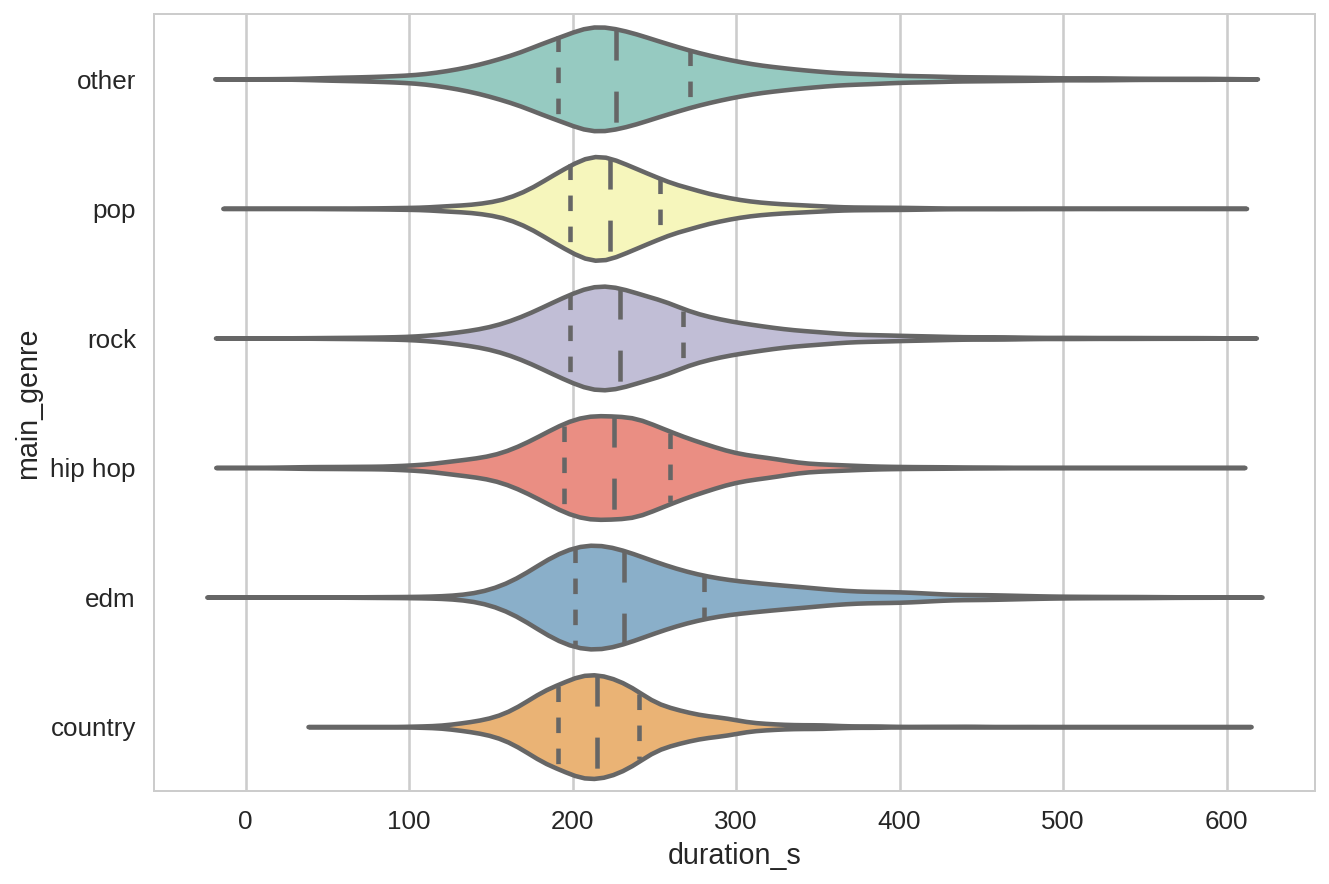

In [32]:
ax = sns.violinplot(x="duration_s", y="main_genre",
data=df_gd, inner='quartile', scale="width", palette="Set3")

## Song Duration By Year

In [0]:



tracks2['duration_ms']
#convert ms to minutes 
tracks2["minutes"]=np.round(tracks2['duration_ms']/60000,decimals=1)




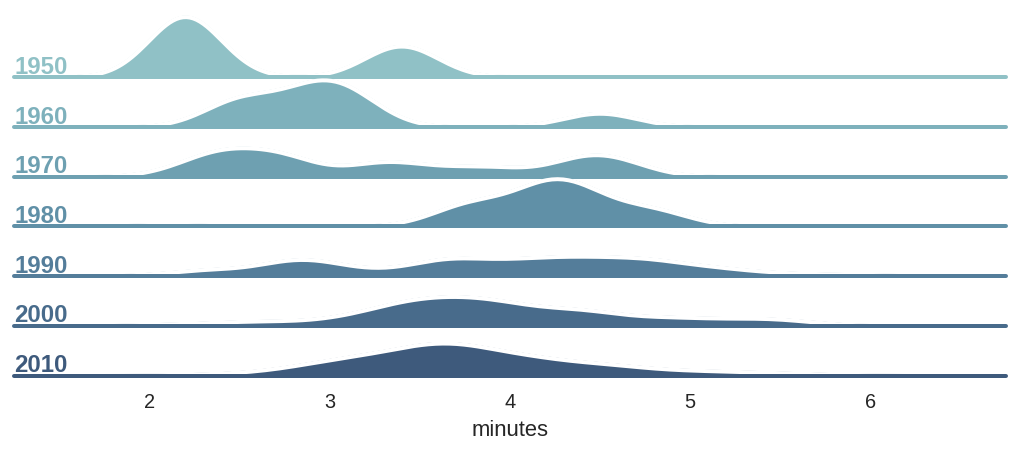

In [0]:
Conditions = (tracks2['minutes']<6) &(tracks2['minutes']>2) & (tracks2['decade']>=1950)



sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})



# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(tracks2[Conditions], row="decade", hue="decade", aspect=15, size=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "minutes", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "minutes", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "minutes")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

## Artist Discovery

In [69]:

#Input Artist
Artist_Input='Blake Shelton'


#Calculate Artists that tend to be in same playlist as Artist
Artist=(tracks2['artist_name']==Artist_Input)

Playlist_Artist = tracks2[[ 'pid','artist_name']].drop_duplicates()



# Playlist_Artist

Artist_Combo= pd.merge(Playlist_Artist[Artist], Playlist_Artist,on='pid', how='inner')


Condition= (Artist_Combo['artist_name_x']!=Artist_Combo['artist_name_y'])

Artist_Combo[Condition]

Artist_Combo_Score = pd.pivot_table(
    data = Artist_Combo[Condition], 
    index = 'artist_name_y', # specifies the rows
    columns = 'artist_name_x',
    values = 'pid',  # specifies the content of the cells
    aggfunc = 'count', # we ask to count how many different CAMIS values we see,
    fill_value = 0
)



# Score Ratio : If you listen to this artist, you might like this one that a lot of people have in their playlist as well
Artist_Combo_Score.sort_values(Artist_Input, ascending = False)[:10]/Artist_Combo_Score.mean()



artist_name_x,Blake Shelton
artist_name_y,
Luke Bryan,100.398666
Florida Georgia Line,94.765282
Tim McGraw,88.717169
Thomas Rhett,86.367045
Kenny Chesney,82.980103
Dierks Bentley,82.807299
Jason Aldean,82.461693
Keith Urban,81.666798
Sam Hunt,81.148388


##Track Attributes By Artist or Genre

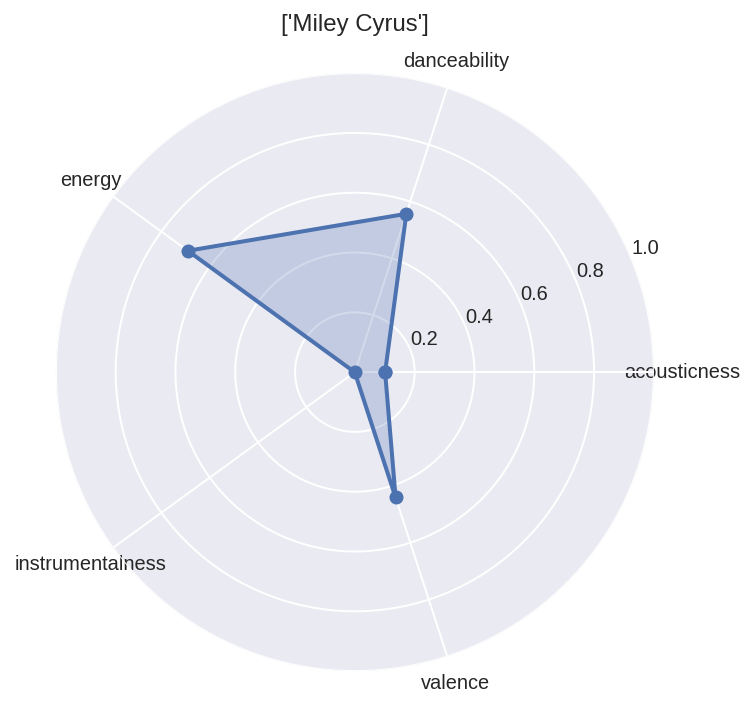

In [66]:
#Input Artist
Artist_Input='Miley Cyrus'
Genre_Input=''


Name=Artist_Input+Genre_Input

#Calculate Artists that tend to be in sam playlist as Artist
Artist=(tracks2['artist_name']==Artist_Input) | (tracks2['genres']==Genre_Input)


Attributes=tracks2[Artist][['acousticness', 'danceability', 'energy', 'instrumentalness', 'valence']].describe().loc[['mean']]







# Radar Plot

# Define Labels
labels=np.array(['acousticness', 'danceability', 'energy', 'instrumentalness','valence'])
stats=Attributes.values[0]





angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False) # Set the angle
# close the plot
stats=np.concatenate((stats,[stats[0]]))  # Closed
angles=np.concatenate((angles,[angles[0]]))  # Closed



fig=sns.plt.figure()
ax = fig.add_subplot(111, polar=True)   # Set polar axis
ax.plot(angles, stats, 'o-', linewidth=2)  # Draw the plot (or the frame on the radar chart)
ax.fill(angles, stats, alpha=0.25)  #Fulfill the area
ax.set_thetagrids(angles * 180/np.pi, labels)  # Set the label for each axis
ax.set_title([Name])  # Set the Artist's name as the title
ax.set_rlim(0,1)
ax.grid(True)

##Distribution of Song Metrics

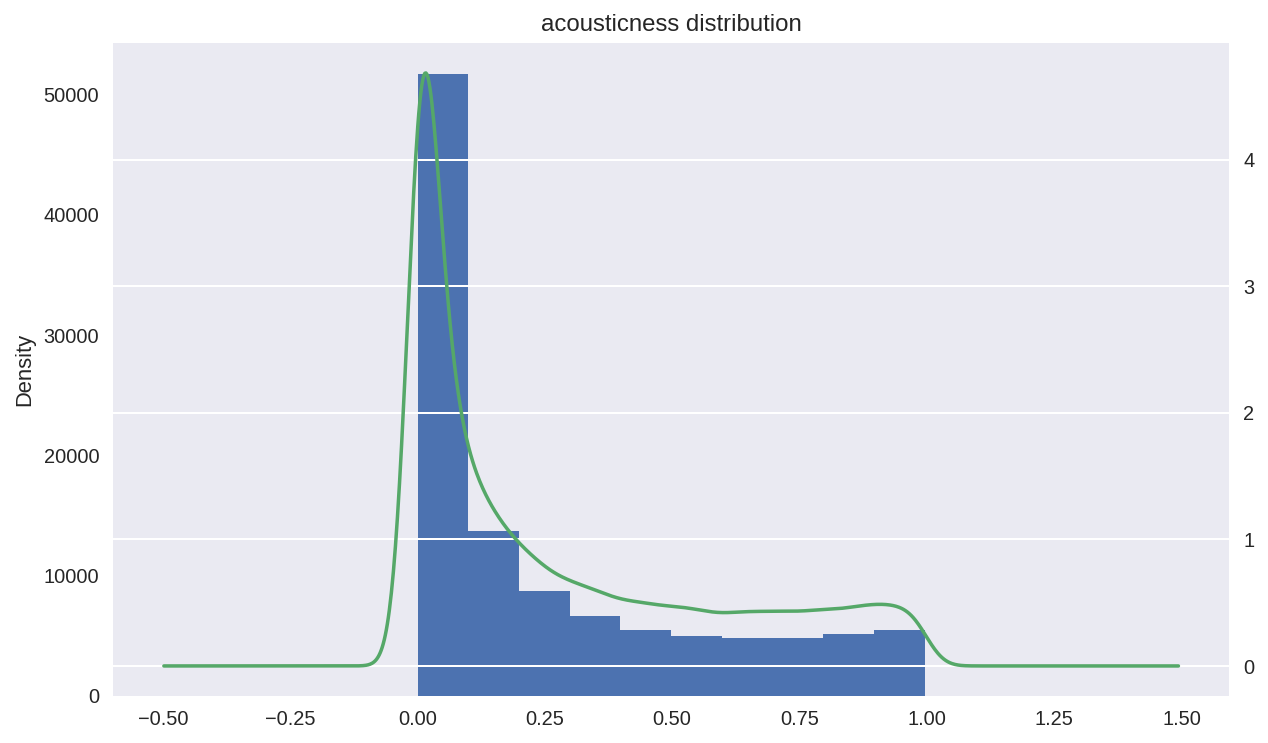

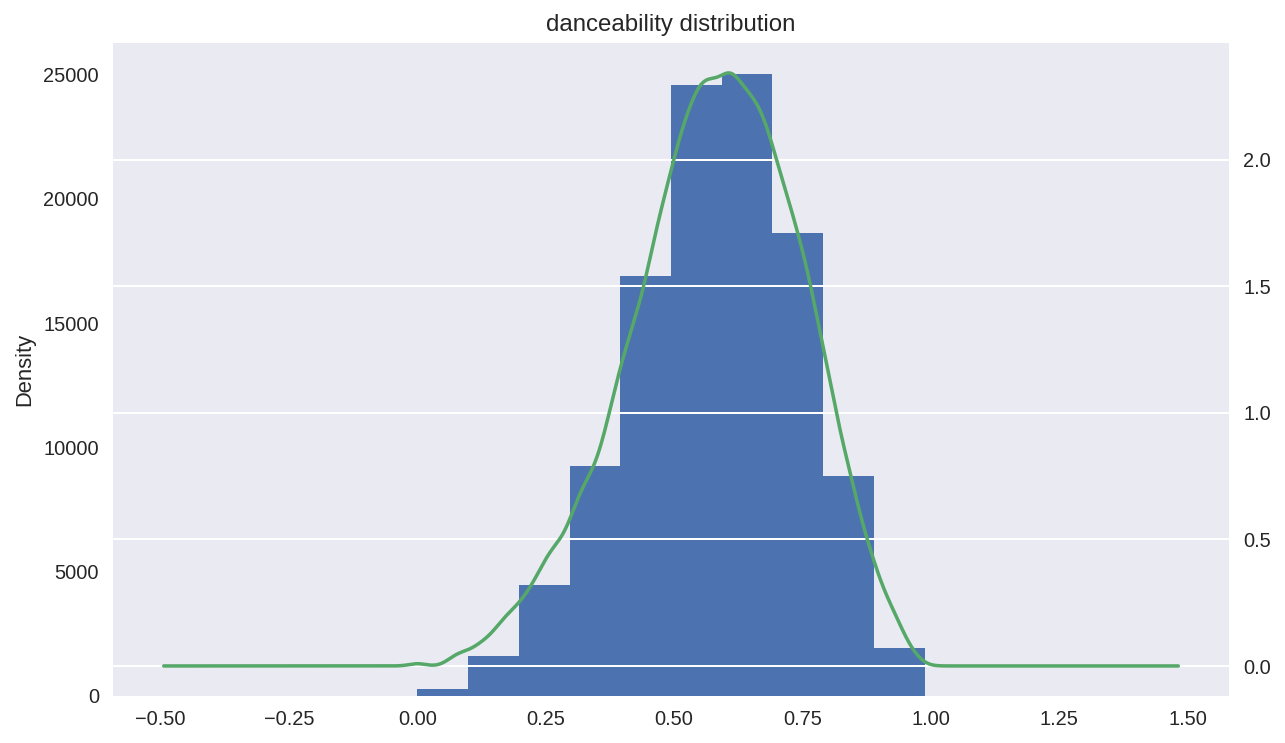

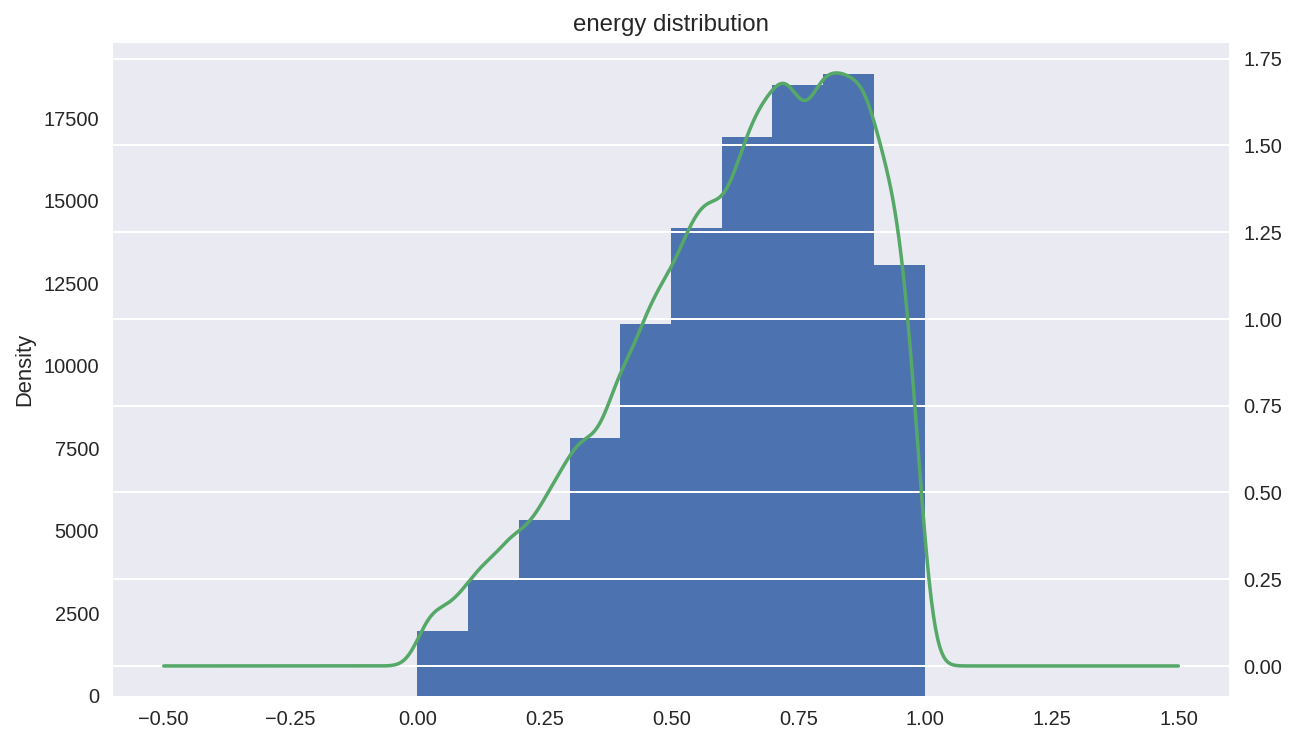

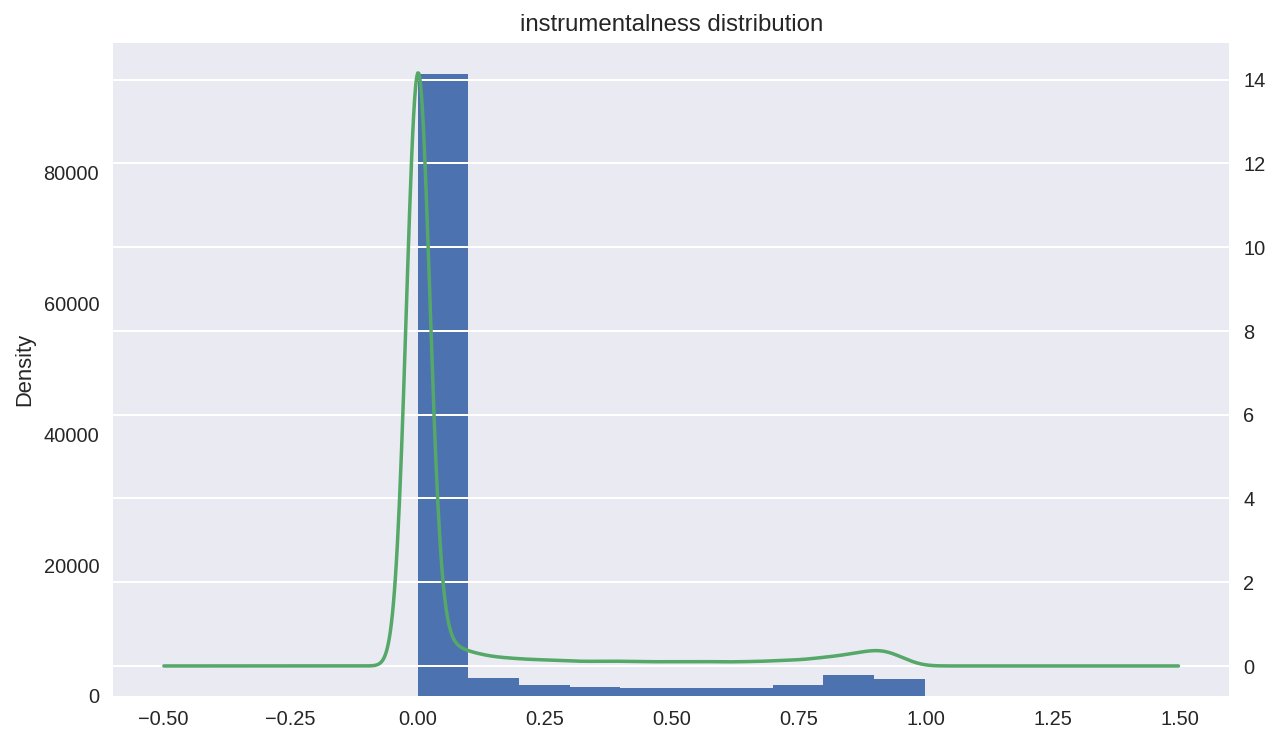

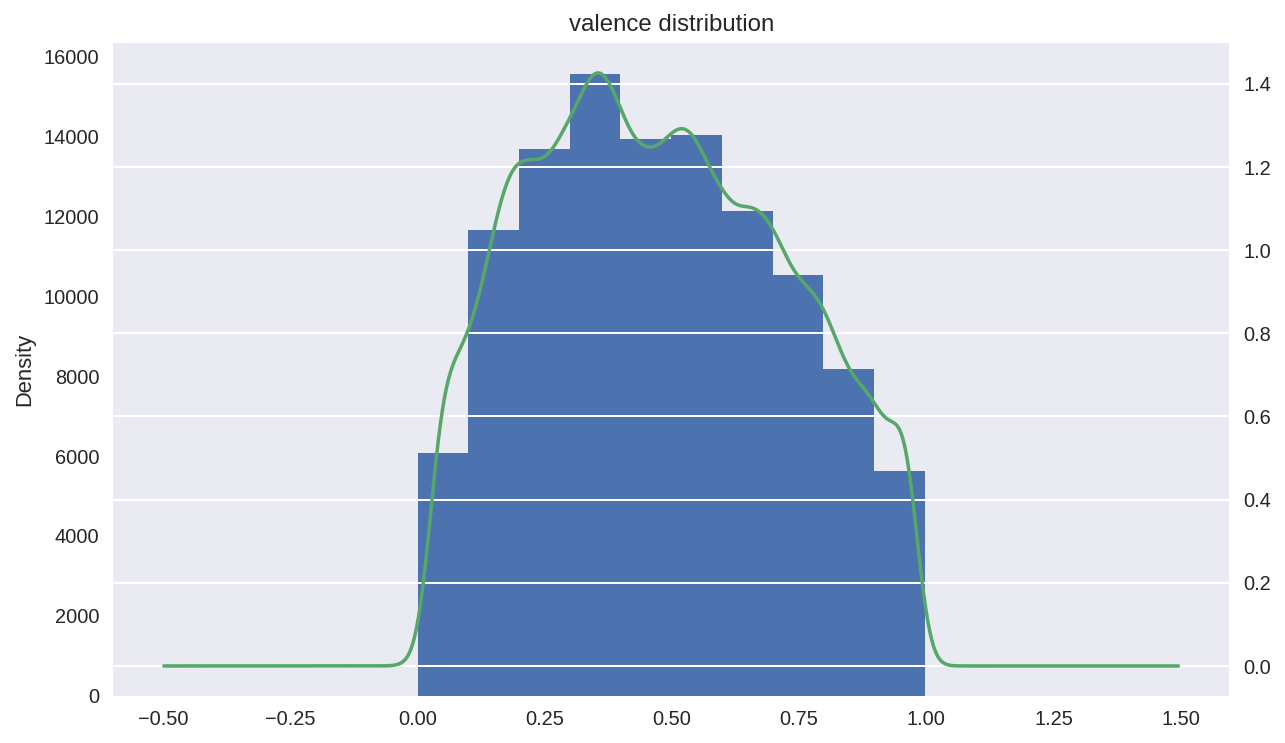

In [43]:

Track_metrics = tracks2[['track_name','acousticness', 'danceability', 'energy', 'instrumentalness','valence']].drop_duplicates()



Attr=['acousticness', 'danceability', 'energy', 'instrumentalness','valence']



## Plot distribution for each metric
for x in Attr:

  
  fig, ax1 = plt.subplots(1,1, figsize=(10,6))
  sns.set()
  ax1 = Track_metrics[x].plot(kind = 'hist', grid = True)
  Track_metrics[x].plot(kind = 'kde', secondary_y = True, ax = ax1)
  ax1.set_title(x+' distribution')



